# Task a:  Fine-tune a pretrained model using the DeepDRiD dataset (ResNet34)

In [1]:
import copy
import os
import random
import sys

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, accuracy_score
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm

# Hyper Parameters
batch_size =24
num_classes = 5  # 5 DR levels
learning_rate = 0.0001
num_epochs = 25


class RetinopathyDataset(Dataset):
    def __init__(self, ann_file, image_dir, transform=None, mode='single', test=False):
        self.ann_file = ann_file
        self.image_dir = image_dir
        self.transform = transform

        self.test = test
        self.mode = mode

        if self.mode == 'single':
            self.data = self.load_data()
        else:
            self.data = self.load_data_dual()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.mode == 'single':
            return self.get_item(index)
        else:
            return self.get_item_dual(index)

    # 1. single image
    def load_data(self):
        df = pd.read_csv(self.ann_file)

        data = []
        for _, row in df.iterrows():
            file_info = dict()
            file_info['img_path'] = os.path.join(self.image_dir, row['img_path'])
            if not self.test:
                file_info['dr_level'] = int(row['patient_DR_Level'])
            data.append(file_info)
        return data

    def get_item(self, index):
        data = self.data[index]
        img = Image.open(data['img_path']).convert('RGB')
        if self.transform:
            img = self.transform(img)

        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return img, label
        else:
            return img

    # 2. dual image
    def load_data_dual(self):
        df = pd.read_csv(self.ann_file)

        df['prefix'] = df['image_id'].str.split('_').str[0]  # The patient id of each image
        df['suffix'] = df['image_id'].str.split('_').str[1].str[0]  # The left or right eye
        grouped = df.groupby(['prefix', 'suffix'])

        data = []
        for (prefix, suffix), group in grouped:
            file_info = dict()
            file_info['img_path1'] = os.path.join(self.image_dir, group.iloc[0]['img_path'])
            file_info['img_path2'] = os.path.join(self.image_dir, group.iloc[1]['img_path'])
            if not self.test:
                file_info['dr_level'] = int(group.iloc[0]['patient_DR_Level'])
            data.append(file_info)
        return data

    def get_item_dual(self, index):
        data = self.data[index]
        img1 = Image.open(data['img_path1']).convert('RGB')
        img2 = Image.open(data['img_path2']).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return [img1, img2], label
        else:
            return [img1, img2]


class CutOut(object):
    def __init__(self, mask_size, p=0.5):
        self.mask_size = mask_size
        self.p = p

    def __call__(self, img):
        if np.random.rand() > self.p:
            return img

        # Ensure the image is a tensor
        if not isinstance(img, torch.Tensor):
            raise TypeError('Input image must be a torch.Tensor')

        # Get height and width of the image
        h, w = img.shape[1], img.shape[2]
        mask_size_half = self.mask_size // 2
        offset = 1 if self.mask_size % 2 == 0 else 0

        cx = np.random.randint(mask_size_half, w + offset - mask_size_half)
        cy = np.random.randint(mask_size_half, h + offset - mask_size_half)

        xmin, xmax = cx - mask_size_half, cx + mask_size_half + offset
        ymin, ymax = cy - mask_size_half, cy + mask_size_half + offset
        xmin, xmax = max(0, xmin), min(w, xmax)
        ymin, ymax = max(0, ymin), min(h, ymax)

        img[:, ymin:ymax, xmin:xmax] = 0
        return img


class SLORandomPad:
    def __init__(self, size):
        self.size = size

    def __call__(self, img):
        pad_width = max(0, self.size[0] - img.width)
        pad_height = max(0, self.size[1] - img.height)
        pad_left = random.randint(0, pad_width)
        pad_top = random.randint(0, pad_height)
        pad_right = pad_width - pad_left
        pad_bottom = pad_height - pad_top
        return transforms.functional.pad(img, (pad_left, pad_top, pad_right, pad_bottom))


class FundRandomRotate:
    def __init__(self, prob, degree):
        self.prob = prob
        self.degree = degree

    def __call__(self, img):
        if random.random() < self.prob:
            angle = random.uniform(-self.degree, self.degree)
            return transforms.functional.rotate(img, angle)
        return img


transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((210, 210)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def train_model(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs=25,
                checkpoint_path='model.pth'):
    best_model = model.state_dict()
    best_epoch = None
    best_val_kappa = -1.0  # Initialize the best kappa score

    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        running_loss = []
        all_preds = []
        all_labels = []

        model.train()

        # Training Phase
        with tqdm(total=len(train_loader), desc=f'Training', unit=' batch', file=sys.stdout) as pbar:
            for images, labels in train_loader:
                if not isinstance(images, list):
                    images = images.to(device)  # single image case
                else:
                    images = [x.to(device) for x in images]  # dual images case

                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(images)
                loss = criterion(outputs, labels.long())

                loss.backward()
                optimizer.step()

                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                running_loss.append(loss.item())

                pbar.set_postfix({'lr': f'{optimizer.param_groups[0]["lr"]:.1e}', 'Loss': f'{loss.item():.4f}'})
                pbar.update(1)

        lr_scheduler.step()

        epoch_loss = sum(running_loss) / len(running_loss)

        train_metrics = compute_metrics(all_preds, all_labels, per_class=True)
        kappa, accuracy, precision, recall = train_metrics[:4]

        print(f'[Train] Kappa: {kappa:.4f} Accuracy: {accuracy:.4f} '
              f'Precision: {precision:.4f} Recall: {recall:.4f} Loss: {epoch_loss:.4f}')

        if len(train_metrics) > 4:
            precision_per_class, recall_per_class = train_metrics[4:]
            for i, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
                print(f'[Train] Class {i}: Precision: {precision:.4f}, Recall: {recall:.4f}')

        # Validation Phase
        model.eval()
        val_loss = []
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                if not isinstance(images, list):
                    images = images.to(device)  # single image case
                else:
                    images = [x.to(device) for x in images]  # dual images case

                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels.long())
                val_loss.append(loss.item())

                preds = torch.argmax(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss = sum(val_loss) / len(val_loss)

        val_metrics = compute_metrics(val_preds, val_labels, per_class=False)
        val_kappa, val_accuracy, val_precision, val_recall = val_metrics[:4]

        print(f'[Val] Kappa: {val_kappa:.4f} Accuracy: {val_accuracy:.4f} '
              f'Precision: {val_precision:.4f} Recall: {val_recall:.4f} Loss: {val_loss:.4f}')

        # Save the best model
        if val_kappa > best_val_kappa:
            best_val_kappa = val_kappa
            best_epoch = epoch
            best_model = model.state_dict()
            torch.save(best_model, checkpoint_path)

    print(f'[Val] Best kappa: {best_val_kappa:.4f}, Epoch {best_epoch}')

    return model

def evaluate_model(model, test_loader, device, test_only=False, prediction_path='/kaggle/working/test_predictionsresnet34.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                image_ids = [
                    os.path.basename(test_loader.dataset.data[idx]['img_path']) for idx in
                    range(i * test_loader.batch_size, i * test_loader.batch_size + len(images))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        metrics = compute_metrics(all_preds, all_labels)
        return metrics


def compute_metrics(preds, labels, per_class=False):
    kappa = cohen_kappa_score(labels, preds, weights='quadratic')
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)

    # Calculate and print precision and recall for each class
    if per_class:
        precision_per_class = precision_score(labels, preds, average=None, zero_division=0)
        recall_per_class = recall_score(labels, preds, average=None, zero_division=0)
        return kappa, accuracy, precision, recall, precision_per_class, recall_per_class

    return kappa, accuracy, precision, recall


class MyModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.resnet34(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x


class MyDualModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        backbone = models.resnet34(pretrained=True)
        backbone.fc = nn.Identity()

        # Here the two backbones will have the same structure but unshared weights
        self.backbone1 = copy.deepcopy(backbone)
        self.backbone2 = copy.deepcopy(backbone)

        self.fc = nn.Sequential(
            nn.Linear(512 * 2, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, images):
        image1, image2 = images

        x1 = self.backbone1(image1)
        x2 = self.backbone2(image2)

        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x


if __name__ == '__main__':
    # Choose between 'single image' and 'dual images' pipeline
    # This will affect the model definition, dataset pipeline, training and evaluation

    mode = 'single'  # forward single image to the model each time
    # mode = 'dual'  # forward two images of the same eye to the model and fuse the features

    assert mode in ('single', 'dual')

    # Define the model
    if mode == 'single':
        model = MyModel()
    else:
        model = MyDualModel()

    print(model, '\n')
    print('Pipeline Mode:', mode)

    # Create datasets
    train_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/train.csv', '/kaggle/input/deepdrid/DeepDRiD/train/', transform_train, mode)
    val_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/val.csv', '/kaggle/input/deepdrid/DeepDRiD/val/', transform_test, mode)
    test_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/test.csv', '/kaggle/input/deepdrid/DeepDRiD/test/', transform_test, mode, test=True)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the weighted CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()

    # Use GPU device is possible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    # Move class weights to the device
    model = model.to(device)

    # Optimizer and Learning rate scheduler
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train and evaluate the model with the training and validation set
    model = train_model(
        model, train_loader, val_loader, device, criterion, optimizer,
        lr_scheduler=lr_scheduler, num_epochs=num_epochs,
        checkpoint_path='/kaggle/working/model_resnet34.pth'
    )

    # Load the pretrained checkpoint
    state_dict = torch.load('/kaggle/working/model_resnet34.pth', map_location='cpu')
    model.load_state_dict(state_dict, strict=True)

    # Make predictions on testing set and save the prediction results
    evaluate_model(model, test_loader, device, test_only=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 209MB/s]


MyModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

<ipython-input-1-62f1adba737c>:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/kaggle/working/model_resnet34.pth', map_location='cpu')


[Val] Kappa: 0.7962 Accuracy: 0.6600 Precision: 0.6411 Recall: 0.6600 Loss: 1.0571
[Val] Best kappa: 0.8092, Epoch 7
Evaluating: 100%|██████████| 17/17 [00:06<00:00,  2.82 batch/s]
[Test] Save predictions to /kaggle/working/test_predictionsresnet34.csv


# Task e: Creating Visualizations and Explainable AI (ResNet34)


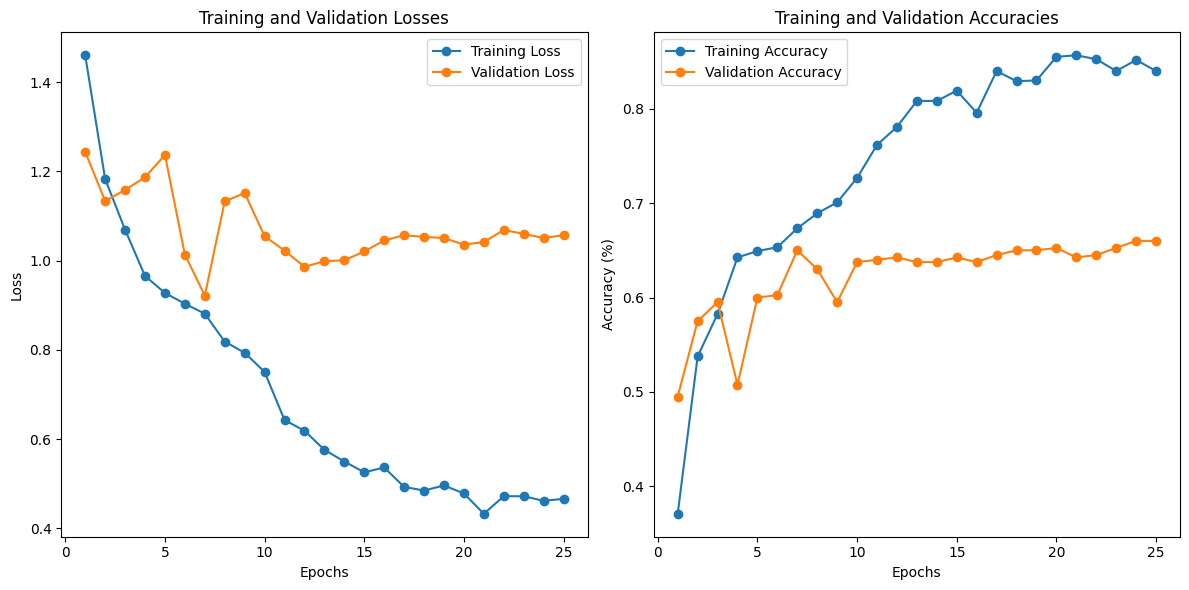

In [12]:
import matplotlib.pyplot as plt


epochs = list(range(1, 26))
train_losses = [1.4603, 1.1830, 1.0693, 0.9657, 0.9276, 0.9034, 0.8811, 0.8184, 0.7937, 0.7505, 0.6427, 0.6188, 0.5760, 0.5498, 0.5255, 0.5364, 0.4929, 0.4847, 0.4961, 0.4782, 0.4326, 0.4720, 0.4719, 0.4617, 0.4661] 
val_losses = [1.2440, 1.1337, 1.1584, 1.1869, 1.2369, 1.0136, 0.9215, 1.1329, 1.1515, 1.0546, 1.0225, 0.9861, 0.9988, 1.0008, 1.0206, 1.0452, 1.0569, 1.0532, 1.0506, 1.0358, 1.0416, 1.0687, 1.0599, 1.0508, 1.0571]

train_accuracies = [0.3708, 0.5375, 0.5825, 0.6425, 0.6492, 0.6533, 0.6733, 0.6892, 0.7008, 0.7267, 0.7617, 0.7808, 0.8083, 0.8083, 0.8192, 0.7958, 0.8400, 0.8292, 0.8300, 0.8550, 0.8567, 0.8525, 0.8400, 0.8517, 0.8400] 
val_accuracies = [0.4950, 0.5750, 0.5950, 0.5075, 0.6000, 0.6025, 0.6500, 0.6300, 0.5950, 0.6375, 0.6400, 0.6425, 0.6375, 0.6375, 0.6425, 0.6375, 0.6450, 0.6500, 0.6500, 0.6525, 0.6425, 0.6450, 0.6525, 0.6600, 0.6600]

# Ensure that the lengths of the lists are the same
min_length = min(len(epochs), len(train_losses), len(val_losses), len(train_accuracies), len(val_accuracies))
epochs = epochs[:min_length]
train_losses = train_losses[:min_length]
val_losses = val_losses[:min_length]
train_accuracies = train_accuracies[:min_length]
val_accuracies = val_accuracies[:min_length]

# Plotting the losses
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses,label='Training Loss', marker='o')
plt.plot(epochs,val_losses,label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Plotting the accuracies
plt.subplot(1 ,2 ,2)
plt.plot(epochs ,train_accuracies,label='Training Accuracy', marker='o')
plt.plot(epochs,val_accuracies,label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracies')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


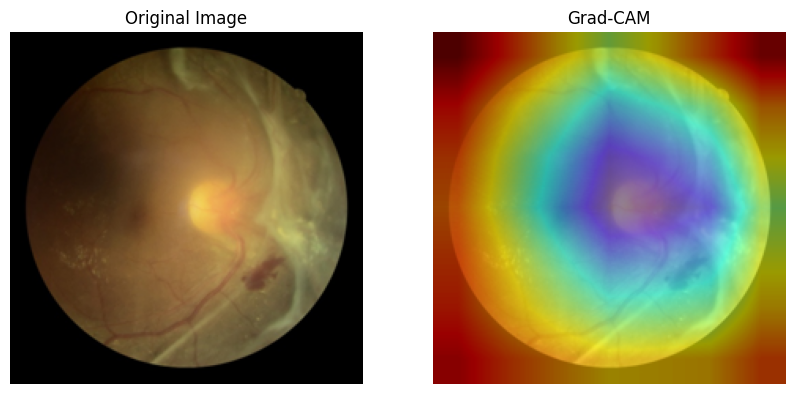

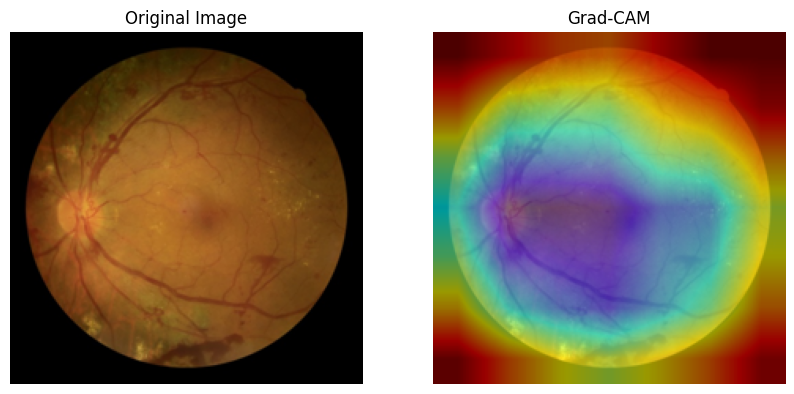

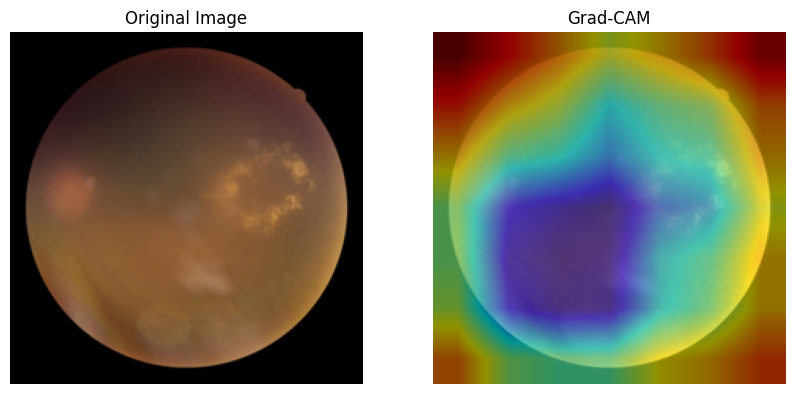

In [13]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define the GradCAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook to get the gradients of the target layer
        target_layer.register_full_backward_hook(self.save_gradients)
        # Hook to get the activations of the target layer
        target_layer.register_forward_hook(self.save_activations)

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def save_activations(self, module, input, output):
        self.activations = output

    def generate(self, input_image, target_class=None):
        # Forward pass
        output = self.model(input_image)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Zero gradients
        self.model.zero_grad()
        # Backward pass with respect to the target class
        output[:, target_class].backward()

        # Get the gradients and activations
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        # Compute the weights
        weights = np.mean(gradients, axis=(1, 2))

        # Compute the Grad-CAM map
        grad_cam_map = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            grad_cam_map += w * activations[i]

        # Apply ReLU to the Grad-CAM map
        grad_cam_map = np.maximum(grad_cam_map, 0)

        # Normalize the Grad-CAM map
        grad_cam_map -= grad_cam_map.min()
        grad_cam_map /= grad_cam_map.max()

        return grad_cam_map

# Load the pre-trained ResNet34 model with updated weights parameter
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model.eval()

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the images
image_paths = ['/kaggle/input/deepdrid/DeepDRiD/test/347/347_r1.jpg', '/kaggle/input/deepdrid/DeepDRiD/test/354/354_l2.jpg', '/kaggle/input/deepdrid/DeepDRiD/test/377/377_l1.jpg']  # Replace with your image paths
images = [Image.open(img_path).convert('RGB') for img_path in image_paths]
input_images = torch.stack([transform(img) for img in images])

# Move the input images to the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_images = input_images.to(device)
model.to(device)

# Initialize GradCAM with the model and target layer (last convolutional layer)
grad_cam = GradCAM(model, model.layer4[2].conv2)

# Generate and visualize Grad-CAM maps for each image
for i in range(len(images)):
    grad_cam_map = grad_cam.generate(input_images[i].unsqueeze(0))

    # Resize the Grad-CAM map to match the input image size
    grad_cam_map = cv2.resize(grad_cam_map, (224, 224))

    # Convert the Grad-CAM map to a heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # Superimpose the heatmap on the original image
    original_image = np.array(images[i].resize((224, 224))) / 255.0
    superimposed_image = heatmap + original_image
    superimposed_image /= superimposed_image.max()

    # Display the original image and Grad-CAM result side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_image)
    plt.title('Grad-CAM')
    plt.axis('off')

    plt.show()


# Task c: Incorporate attention mechanisms in the model.( Spatial-attention mechanism in ResNet34)

In [14]:


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), "Kernel size must be 3 or 7"
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        attention_map = self.conv(torch.cat([avg_out, max_out], dim=1))
        attention_map = self.sigmoid(attention_map)
        return x * attention_map  # Ensure the attention map is applied correctly




class MyModelWithSpatialAttention(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.resnet34(pretrained=True)
        self.backbone.fc = nn.Identity()
        self.spatial_attention = SpatialAttention()

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)  # Outputs (batch_size, 512)
        x = x.view(x.size(0), 512, 1, 1)  # Reshape to (batch_size, 512, 1, 1) for attention
        x = self.spatial_attention(x)  # Apply spatial attention
        x = torch.flatten(x, start_dim=1)  # Flatten before fully connected layer
        x = self.fc(x)
        return x
    
    
    
    
    
    


class MyDualModelWithSpatialAttention(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        backbone = models.resnet34(pretrained=True)
        backbone.fc = nn.Identity()

        self.backbone1 = copy.deepcopy(backbone)
        self.backbone2 = copy.deepcopy(backbone)

        self.spatial_attention1 = SpatialAttention()
        self.spatial_attention2 = SpatialAttention()

        self.fc = nn.Sequential(
            nn.Linear(512 * 2, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, images):
        image1, image2 = images

        x1 = self.backbone1(image1)
        x2 = self.backbone2(image2)

        x1 = self.spatial_attention1(x1)
        x2 = self.spatial_attention2(x2)

        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x

if __name__ == '__main__':
    mode = 'single'

    if mode == 'single':
        model = MyModelWithSpatialAttention()
    else:
        model = MyDualModelWithSpatialAttention()

    train_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/train.csv', '/kaggle/input/deepdrid/DeepDRiD/train/', transform_train, mode)
    val_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/val.csv', '/kaggle/input/deepdrid/DeepDRiD/val/', transform_test, mode)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    def train_model(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs=25):
        best_model = model.state_dict()
        best_epoch = None
        best_val_kappa = -1.0

        for epoch in range(1, num_epochs + 1):
            print(f'\nEpoch {epoch}/{num_epochs}')
            model.train()

            running_loss = []
            all_preds = []
            all_labels = []

            with tqdm(total=len(train_loader), desc=f'Training', unit='batch') as pbar:
                for images, labels in train_loader:
                    if isinstance(images, list):
                        images = [img.to(device) for img in images]
                    else:
                        images = images.to(device)

                    labels = labels.to(device)

                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    preds = torch.argmax(outputs, dim=1)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

                    running_loss.append(loss.item())

                    pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
                    pbar.update(1)

            lr_scheduler.step()

            epoch_loss = np.mean(running_loss)
            kappa = cohen_kappa_score(all_labels, all_preds, weights='quadratic')

            print(f'[Train] Loss: {epoch_loss:.4f} Kappa: {kappa:.4f}')

            # Validate the model
            model.eval()
            val_loss = []
            val_preds = []
            val_labels = []

            with torch.no_grad():
                for images, labels in val_loader:
                    if isinstance(images, list):
                        images = [img.to(device) for img in images]
                    else:
                        images = images.to(device)

                    labels = labels.to(device)

                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    preds = torch.argmax(outputs, dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

                    val_loss.append(loss.item())

            val_epoch_loss = np.mean(val_loss)
            val_kappa = cohen_kappa_score(val_labels, val_preds, weights='quadratic')

            print(f'[Val] Loss: {val_epoch_loss:.4f} Kappa: {val_kappa:.4f}')

            if val_kappa > best_val_kappa:
                best_val_kappa = val_kappa
                best_model = copy.deepcopy(model.state_dict())
                best_epoch = epoch

        print(f'Best Validation Kappa: {best_val_kappa:.4f} at Epoch {best_epoch}')
        model.load_state_dict(best_model)
        return model

    model = train_model(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/25


Training: 100%|██████████| 50/50 [00:12<00:00,  4.07batch/s, Loss=1.5748]


[Train] Loss: 1.4975 Kappa: 0.3833
[Val] Loss: 1.2499 Kappa: 0.6445

Epoch 2/25


Training: 100%|██████████| 50/50 [00:11<00:00,  4.50batch/s, Loss=1.3812]


[Train] Loss: 1.1937 Kappa: 0.6622
[Val] Loss: 1.1031 Kappa: 0.6203

Epoch 3/25


Training: 100%|██████████| 50/50 [00:11<00:00,  4.54batch/s, Loss=1.2521]


[Train] Loss: 1.0661 Kappa: 0.7401
[Val] Loss: 1.0685 Kappa: 0.7341

Epoch 4/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.57batch/s, Loss=1.0823]


[Train] Loss: 1.0113 Kappa: 0.7615
[Val] Loss: 1.1272 Kappa: 0.5899

Epoch 5/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.65batch/s, Loss=0.8022]


[Train] Loss: 0.9714 Kappa: 0.7792
[Val] Loss: 0.9517 Kappa: 0.7339

Epoch 6/25


Training: 100%|██████████| 50/50 [00:11<00:00,  4.54batch/s, Loss=0.6760]


[Train] Loss: 0.8697 Kappa: 0.8116
[Val] Loss: 0.9761 Kappa: 0.7531

Epoch 7/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.55batch/s, Loss=1.3155]


[Train] Loss: 0.8339 Kappa: 0.8233
[Val] Loss: 1.4571 Kappa: 0.7633

Epoch 8/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.65batch/s, Loss=0.5073]


[Train] Loss: 0.8479 Kappa: 0.8063
[Val] Loss: 0.9410 Kappa: 0.7517

Epoch 9/25


Training: 100%|██████████| 50/50 [00:11<00:00,  4.53batch/s, Loss=0.6295]


[Train] Loss: 0.8043 Kappa: 0.8355
[Val] Loss: 1.0365 Kappa: 0.7073

Epoch 10/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.55batch/s, Loss=0.5982]


[Train] Loss: 0.7231 Kappa: 0.8537
[Val] Loss: 0.9691 Kappa: 0.8052

Epoch 11/25


Training: 100%|██████████| 50/50 [00:11<00:00,  4.51batch/s, Loss=0.7226]


[Train] Loss: 0.6325 Kappa: 0.8869
[Val] Loss: 0.9764 Kappa: 0.7986

Epoch 12/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.59batch/s, Loss=0.5745]


[Train] Loss: 0.6190 Kappa: 0.8864
[Val] Loss: 0.9926 Kappa: 0.8119

Epoch 13/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.62batch/s, Loss=0.3869]


[Train] Loss: 0.5842 Kappa: 0.9071
[Val] Loss: 0.9898 Kappa: 0.8089

Epoch 14/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.62batch/s, Loss=0.3999]


[Train] Loss: 0.5291 Kappa: 0.9096
[Val] Loss: 0.9920 Kappa: 0.8006

Epoch 15/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.60batch/s, Loss=0.5582]


[Train] Loss: 0.5462 Kappa: 0.9221
[Val] Loss: 0.9827 Kappa: 0.8050

Epoch 16/25


Training: 100%|██████████| 50/50 [00:11<00:00,  4.52batch/s, Loss=0.6389]


[Train] Loss: 0.5598 Kappa: 0.9109
[Val] Loss: 1.0162 Kappa: 0.8078

Epoch 17/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.61batch/s, Loss=0.3698]


[Train] Loss: 0.5605 Kappa: 0.9001
[Val] Loss: 1.0709 Kappa: 0.7751

Epoch 18/25


Training: 100%|██████████| 50/50 [00:11<00:00,  4.53batch/s, Loss=0.6331]


[Train] Loss: 0.5319 Kappa: 0.9174
[Val] Loss: 1.0455 Kappa: 0.7831

Epoch 19/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.60batch/s, Loss=0.3665]


[Train] Loss: 0.4872 Kappa: 0.9239
[Val] Loss: 1.0528 Kappa: 0.7882

Epoch 20/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.58batch/s, Loss=0.7202]


[Train] Loss: 0.5309 Kappa: 0.9135
[Val] Loss: 1.0385 Kappa: 0.8035

Epoch 21/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.59batch/s, Loss=0.3669]


[Train] Loss: 0.4789 Kappa: 0.9233
[Val] Loss: 1.0550 Kappa: 0.8012

Epoch 22/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.68batch/s, Loss=0.7011]


[Train] Loss: 0.5302 Kappa: 0.9090
[Val] Loss: 1.0730 Kappa: 0.7915

Epoch 23/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.60batch/s, Loss=0.3471]


[Train] Loss: 0.4484 Kappa: 0.9260
[Val] Loss: 1.0388 Kappa: 0.8102

Epoch 24/25


Training: 100%|██████████| 50/50 [00:11<00:00,  4.54batch/s, Loss=0.4506]


[Train] Loss: 0.4948 Kappa: 0.9144
[Val] Loss: 1.0609 Kappa: 0.8045

Epoch 25/25


Training: 100%|██████████| 50/50 [00:11<00:00,  4.44batch/s, Loss=0.3566]


[Train] Loss: 0.4685 Kappa: 0.9334
[Val] Loss: 1.0458 Kappa: 0.8051
Best Validation Kappa: 0.8119 at Epoch 12


# Task c: Incorporate attention mechanisms in the model (Self-attention mechanism for ResNet34)

In [15]:


#  Self-Attention Mechanism
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, H, W = x.size()
        query = self.query(x).view(batch_size, -1, H * W).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, H * W)
        attention = self.softmax(torch.bmm(query, key))
        value = self.value(x).view(batch_size, -1, H * W)

        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, H, W)
        out = self.gamma * out + x
        return out



class MyModelWithAttention(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()
        self.backbone = models.resnet34(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        # Add self-attention layer after the ResNet backbone
        self.attention = SelfAttention(in_channels=512)

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.attention(x.unsqueeze(-1).unsqueeze(-1))  # Reshape to include spatial dimensions
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


if __name__ == '__main__':
    # Define the model with self-attention
    model = MyModelWithAttention()
    print(model, '\n')

    # Dataset, dataloader, and optimizer remain unchanged
    train_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/train.csv', '/kaggle/input/deepdrid/DeepDRiD/train/', transform_train, 'single')
    val_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/val.csv', '/kaggle/input/deepdrid/DeepDRiD/val/', transform_test, 'single')
    test_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/test.csv', '/kaggle/input/deepdrid/DeepDRiD/test/', transform_test, 'single', test=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train and evaluate the model with attention
    model = train_model(
        model, train_loader, val_loader, device, criterion, optimizer,
        lr_scheduler=lr_scheduler, num_epochs=num_epochs
        
    )

    # Load the pretrained checkpoint
    state_dict = torch.load('/kaggle/working/resnet34model_with_attention.pth', map_location='cpu')
    model.load_state_dict(state_dict, strict=True)

    # Make predictions on testing set
    evaluate_model(model, test_loader, device, test_only=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MyModelWithAttention(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

Training: 100%|██████████| 50/50 [00:11<00:00,  4.24batch/s, Loss=1.1449]


[Train] Loss: 1.3954 Kappa: 0.3556
[Val] Loss: 1.2781 Kappa: 0.6722

Epoch 2/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.61batch/s, Loss=1.6046]


[Train] Loss: 1.2028 Kappa: 0.6674
[Val] Loss: 1.1098 Kappa: 0.7086

Epoch 3/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.69batch/s, Loss=0.9869]


[Train] Loss: 1.0674 Kappa: 0.7257
[Val] Loss: 1.0007 Kappa: 0.7426

Epoch 4/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.58batch/s, Loss=1.0703]


[Train] Loss: 1.0023 Kappa: 0.7386
[Val] Loss: 0.9757 Kappa: 0.7875

Epoch 5/25


Training: 100%|██████████| 50/50 [00:11<00:00,  4.52batch/s, Loss=0.7966]


[Train] Loss: 0.9250 Kappa: 0.7924
[Val] Loss: 1.0760 Kappa: 0.6850

Epoch 6/25


Training: 100%|██████████| 50/50 [00:11<00:00,  4.52batch/s, Loss=0.9629]


[Train] Loss: 0.9434 Kappa: 0.7829
[Val] Loss: 1.0085 Kappa: 0.7728

Epoch 7/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.61batch/s, Loss=0.7386]


[Train] Loss: 0.8877 Kappa: 0.8014
[Val] Loss: 0.9671 Kappa: 0.7631

Epoch 8/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.59batch/s, Loss=0.9686]


[Train] Loss: 0.8211 Kappa: 0.8278
[Val] Loss: 1.1021 Kappa: 0.7678

Epoch 9/25


Training: 100%|██████████| 50/50 [00:11<00:00,  4.53batch/s, Loss=0.7046]


[Train] Loss: 0.7469 Kappa: 0.8509
[Val] Loss: 1.0003 Kappa: 0.7532

Epoch 10/25


Training: 100%|██████████| 50/50 [00:11<00:00,  4.48batch/s, Loss=0.8599]


[Train] Loss: 0.7817 Kappa: 0.8458
[Val] Loss: 1.1760 Kappa: 0.7080

Epoch 11/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.55batch/s, Loss=0.5692]


[Train] Loss: 0.6869 Kappa: 0.8723
[Val] Loss: 1.0030 Kappa: 0.7732

Epoch 12/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.63batch/s, Loss=0.6480]


[Train] Loss: 0.6024 Kappa: 0.8926
[Val] Loss: 1.0113 Kappa: 0.7780

Epoch 13/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.59batch/s, Loss=0.4830]


[Train] Loss: 0.6063 Kappa: 0.8972
[Val] Loss: 1.0025 Kappa: 0.7821

Epoch 14/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.58batch/s, Loss=0.5978]


[Train] Loss: 0.5901 Kappa: 0.8955
[Val] Loss: 1.0008 Kappa: 0.7860

Epoch 15/25


Training: 100%|██████████| 50/50 [00:11<00:00,  4.50batch/s, Loss=0.4632]


[Train] Loss: 0.5685 Kappa: 0.8997
[Val] Loss: 1.0382 Kappa: 0.7870

Epoch 16/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.57batch/s, Loss=0.4417]


[Train] Loss: 0.5484 Kappa: 0.9026
[Val] Loss: 1.0108 Kappa: 0.8070

Epoch 17/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.61batch/s, Loss=0.5407]


[Train] Loss: 0.5320 Kappa: 0.9045
[Val] Loss: 1.0404 Kappa: 0.7987

Epoch 18/25


Training: 100%|██████████| 50/50 [00:11<00:00,  4.53batch/s, Loss=0.7810]


[Train] Loss: 0.5180 Kappa: 0.9180
[Val] Loss: 1.0706 Kappa: 0.7816

Epoch 19/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.55batch/s, Loss=0.4381]


[Train] Loss: 0.5062 Kappa: 0.9126
[Val] Loss: 1.0374 Kappa: 0.7933

Epoch 20/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.60batch/s, Loss=0.4296]


[Train] Loss: 0.4704 Kappa: 0.9272
[Val] Loss: 1.0488 Kappa: 0.7950

Epoch 21/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.62batch/s, Loss=0.5008]


[Train] Loss: 0.4667 Kappa: 0.9228
[Val] Loss: 1.0542 Kappa: 0.7995

Epoch 22/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.62batch/s, Loss=0.3932]


[Train] Loss: 0.4376 Kappa: 0.9356
[Val] Loss: 1.0610 Kappa: 0.7975

Epoch 23/25


Training: 100%|██████████| 50/50 [00:11<00:00,  4.51batch/s, Loss=0.4156]


[Train] Loss: 0.4632 Kappa: 0.9216
[Val] Loss: 1.0369 Kappa: 0.8033

Epoch 24/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.57batch/s, Loss=0.3040]


[Train] Loss: 0.4945 Kappa: 0.9193
[Val] Loss: 1.0908 Kappa: 0.7867

Epoch 25/25


Training: 100%|██████████| 50/50 [00:10<00:00,  4.56batch/s, Loss=0.5428]


[Train] Loss: 0.4870 Kappa: 0.9205
[Val] Loss: 1.0619 Kappa: 0.8033
Best Validation Kappa: 0.8070 at Epoch 16


<ipython-input-15-cf2a3e88dc99>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/kaggle/working/resnet34model_with_attention.pth', map_location='c

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/resnet34model_with_attention.pth'

# Task a: Fine-tune a pretrained model using the DeepDRiD dataset (VGG16)  

In [16]:


def train_model(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs=25,
                checkpoint_path='/kaggle/working/vgg16_model.pth'):
    best_model = model.state_dict()
    best_epoch = None
    best_val_kappa = -1.0  # Initialize the best kappa score

    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        running_loss = []
        all_preds = []
        all_labels = []

        model.train()

        # Training Phase
        with tqdm(total=len(train_loader), desc=f'Training', unit=' batch', file=sys.stdout) as pbar:
            for images, labels in train_loader:
                if not isinstance(images, list):
                    images = images.to(device)  # single image case
                else:
                    images = [x.to(device) for x in images]  # dual images case

                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(images)
                loss = criterion(outputs, labels.long())

                loss.backward()
                optimizer.step()

                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                running_loss.append(loss.item())

                pbar.set_postfix({'lr': f'{optimizer.param_groups[0]["lr"]:.1e}', 'Loss': f'{loss.item():.4f}'})
                pbar.update(1)

        lr_scheduler.step()

        epoch_loss = sum(running_loss) / len(running_loss)

        train_metrics = compute_metrics(all_preds, all_labels, per_class=True)
        kappa, accuracy, precision, recall = train_metrics[:4]

        print(f'[Train] Kappa: {kappa:.4f} Accuracy: {accuracy:.4f} '
              f'Precision: {precision:.4f} Recall: {recall:.4f} Loss: {epoch_loss:.4f}')

        if len(train_metrics) > 4:
            precision_per_class, recall_per_class = train_metrics[4:]
            for i, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
                print(f'[Train] Class {i}: Precision: {precision:.4f}, Recall: {recall:.4f}')

        # Validation Phase
        model.eval()
        val_loss = []
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                if not isinstance(images, list):
                    images = images.to(device)  # single image case
                else:
                    images = [x.to(device) for x in images]  # dual images case

                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels.long())
                val_loss.append(loss.item())

                preds = torch.argmax(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss = sum(val_loss) / len(val_loss)

        val_metrics = compute_metrics(val_preds, val_labels, per_class=False)
        val_kappa, val_accuracy, val_precision, val_recall = val_metrics[:4]

        print(f'[Val] Kappa: {val_kappa:.4f} Accuracy: {val_accuracy:.4f} '
              f'Precision: {val_precision:.4f} Recall: {val_recall:.4f} Loss: {val_loss:.4f}')

        # Save the best model
        if val_kappa > best_val_kappa:
            best_val_kappa = val_kappa
            best_epoch = epoch
            best_model = model.state_dict()
            torch.save(best_model, checkpoint_path)

    print(f'[Val] Best kappa: {best_val_kappa:.4f}, Epoch {best_epoch}')

    return model


def evaluate_model(model, test_loader, device, test_only=False, prediction_path='/kaggle/working/test_predictions_vgg16.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                image_ids = [
                    os.path.basename(test_loader.dataset.data[idx]['img_path']) for idx in
                    range(i * test_loader.batch_size, i * test_loader.batch_size + len(images))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        metrics = compute_metrics(all_preds, all_labels)
        return metrics

def compute_metrics(preds, labels, per_class=False):
    kappa = cohen_kappa_score(labels, preds, weights='quadratic')
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)

    # Calculate and print precision and recall for each class
    if per_class:
        precision_per_class = precision_score(labels, preds, average=None, zero_division=0)
        recall_per_class = recall_score(labels, preds, average=None, zero_division=0)
        return kappa, accuracy, precision, recall, precision_per_class, recall_per_class

    return kappa, accuracy, precision, recall

class MyModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        self.backbone.classifier = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.backbone.features(x)
        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class MyDualModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        backbone = models.vgg16(pretrained=True)
        backbone.fc = nn.Identity()

        # Here the two backbones will have the same structure but unshared weights
        self.backbone1 = copy.deepcopy(backbone)
        self.backbone2 = copy.deepcopy(backbone)

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
        )

    def forward(self, images):
        image1, image2 = images

        x1 = self.backbone1(image1)
        x2 = self.backbone2(image2)

        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x

if __name__ == '__main__':
    # Choose between 'single image' and 'dual images' pipeline
    # This will affect the model definition, dataset pipeline, training and evaluation

    mode = 'single'  # forward single image to the model each time
    # mode = 'dual'  # forward two images of the same eye to the model and fuse the features

    assert mode in ('single', 'dual')

    # Define the model
    if mode == 'single':
        model = MyModel()
    else:
        model = MyDualModel()

    print(model, '\n')
    print('Pipeline Mode:', mode)

    # Create datasets
    train_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/train.csv', '/kaggle/input/deepdrid/DeepDRiD/train/', transform_train, mode)
    val_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/val.csv', '/kaggle/input/deepdrid/DeepDRiD/val/', transform_test, mode)
    test_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/test.csv', '/kaggle/input/deepdrid/DeepDRiD/test/', transform_test, mode, test=True)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the weighted CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()

    # Use GPU device is possible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    # Move class weights to the device
    model = model.to(device)

    # Optimizer and Learning rate scheduler
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train and evaluate the model with the training and validation set
    model = train_model(
        model, train_loader, val_loader, device, criterion, optimizer,
        lr_scheduler=lr_scheduler, num_epochs=num_epochs
    )

    # Load the pretrained checkpoint
    state_dict = torch.load('/kaggle/working/model_vgg16.pth', map_location='cpu')
    model.load_state_dict(state_dict, strict=True)

    # Make predictions on testing set and save the prediction results
    evaluate_model(model, test_loader, device, test_only=True)

MyModel(
  (backbone): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16

<ipython-input-16-9e53f40436d1>:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/kaggle/working/model_vgg16.pth', map_location='cpu')


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/model_vgg16.pth'

# Task e: Creating Visualizations and Explainable AI (VGG16)


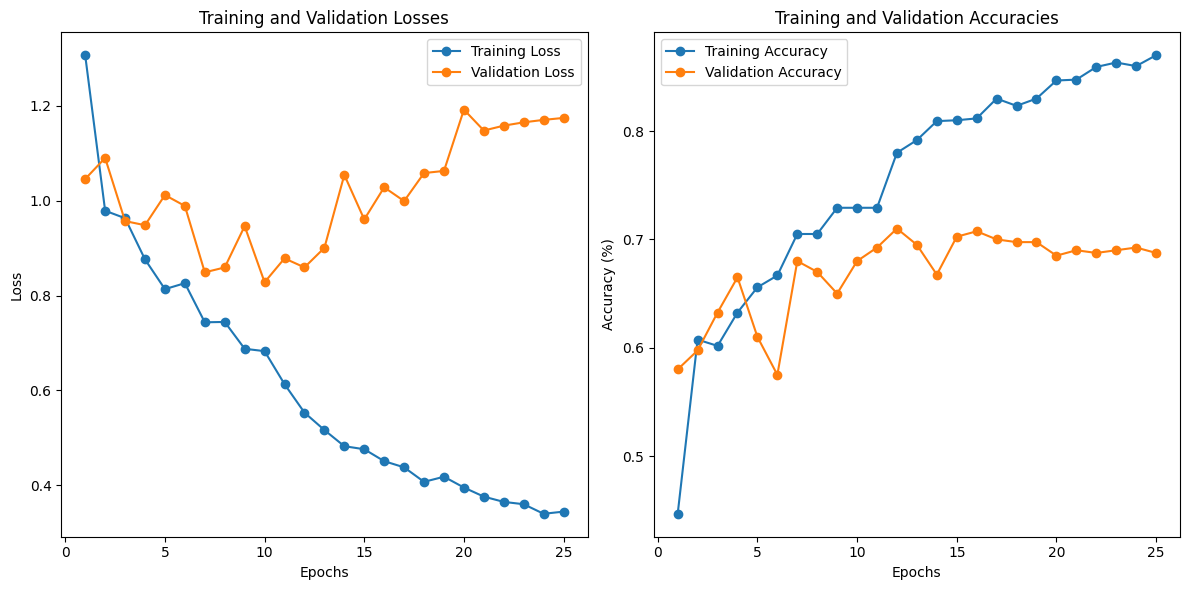

In [17]:
import matplotlib.pyplot as plt


epochs = list(range(1, 26))


train_losses = [1.3070, 0.9790, 0.9633, 0.8764, 0.8136, 0.8262, 0.7437, 0.7444, 0.6878, 0.6828, 0.6132, 0.5532, 0.5164, 0.4823, 0.4759, 0.4507, 0.4377, 0.4071, 0.4179, 0.3951, 0.3759, 0.3648, 0.3599, 0.3397, 0.3443]
val_losses = [1.0460, 1.0904, 0.9572, 0.9485, 1.0121, 0.9892, 0.8491, 0.8594, 0.9465, 0.8282, 0.8785, 0.8595, 0.9007, 1.0546, 0.9607, 1.0284, 0.9994, 1.0585, 1.0630, 1.1923, 1.1482, 1.1585, 1.1655, 1.1707, 1.1748]
train_accuracies = [0.4467, 0.6075, 0.6017, 0.6325, 0.6558, 0.6667, 0.7050, 0.7050, 0.7292, 0.7292, 0.7292, 0.7800, 0.7917, 0.8092, 0.8100, 0.8117, 0.8300, 0.8233, 0.8300, 0.8467, 0.8475, 0.8592, 0.8633, 0.8600, 0.8700]
val_accuracies = [0.5800, 0.5975, 0.6325, 0.6650, 0.6100, 0.5750, 0.6800, 0.6700, 0.6500, 0.6800, 0.6925, 0.7100, 0.6950, 0.6675, 0.7025, 0.7075, 0.7000, 0.6975, 0.6975, 0.6850, 0.6900, 0.6875, 0.6900, 0.6925, 0.6875]
# Ensure that the lengths of the lists are the same
min_length = min(len(epochs), len(train_losses), len(val_losses), len(train_accuracies), len(val_accuracies))
epochs = epochs[:min_length]
train_losses = train_losses[:min_length]
val_losses = val_losses[:min_length]
train_accuracies = train_accuracies[:min_length]
val_accuracies = val_accuracies[:min_length]

# Plotting the losses
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses,label='Training Loss', marker='o')
plt.plot(epochs,val_losses,label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Plotting the accuracies
plt.subplot(1 ,2 ,2)
plt.plot(epochs ,train_accuracies,label='Training Accuracy', marker='o')
plt.plot(epochs,val_accuracies,label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracies')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

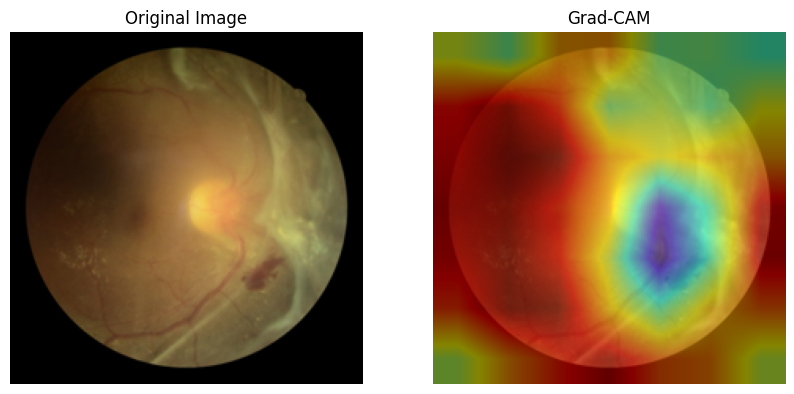

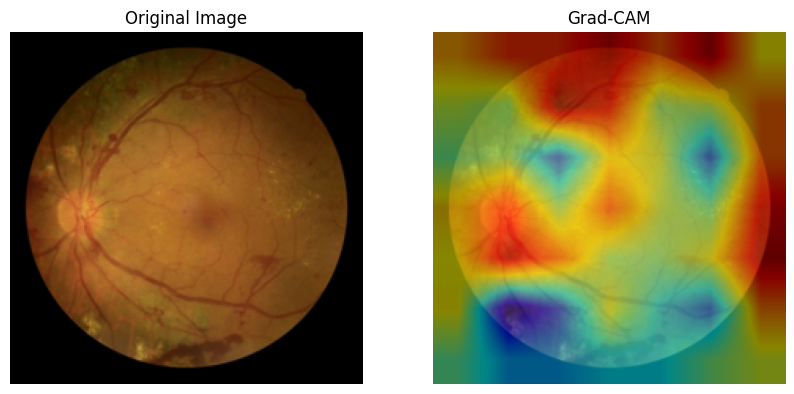

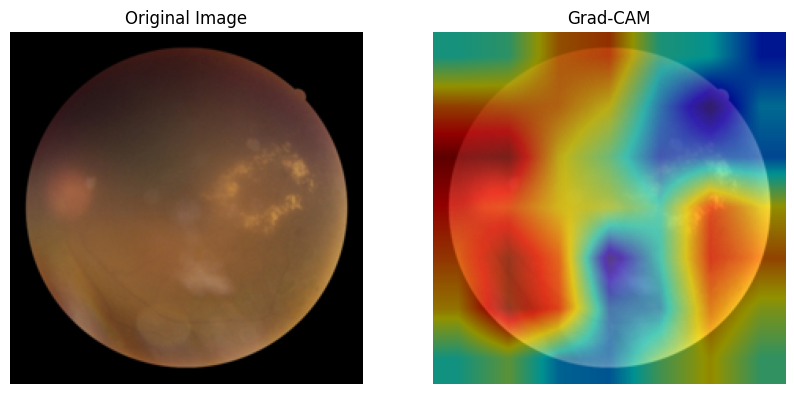

In [19]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define the GradCAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook to get the gradients of the target layer
        target_layer.register_full_backward_hook(self.save_gradients)
        # Hook to get the activations of the target layer
        target_layer.register_forward_hook(self.save_activations)

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def save_activations(self, module, input, output):
        self.activations = output

    def generate(self, input_image, target_class=None):
        # Forward pass
        output = self.model(input_image)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Zero gradients
        self.model.zero_grad()
        # Backward pass with respect to the target class
        output[:, target_class].backward()

        # Get the gradients and activations
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        # Compute the weights
        weights = np.mean(gradients, axis=(1, 2))

        # Compute the Grad-CAM map
        grad_cam_map = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            grad_cam_map += w * activations[i]

        # Apply ReLU to the Grad-CAM map
        grad_cam_map = np.maximum(grad_cam_map, 0)

        # Normalize the Grad-CAM map
        grad_cam_map -= grad_cam_map.min()
        grad_cam_map /= grad_cam_map.max()

        return grad_cam_map

# Load the pre-trained VGG16 model with updated weights parameter
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.eval()

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the images
image_paths = ['/kaggle/input/deepdrid/DeepDRiD/test/347/347_r1.jpg', '/kaggle/input/deepdrid/DeepDRiD/test/354/354_l2.jpg', '/kaggle/input/deepdrid/DeepDRiD/test/377/377_l1.jpg']  # Replace with your image paths
images = [Image.open(img_path).convert('RGB') for img_path in image_paths]
input_images = torch.stack([transform(img) for img in images])

# Move the input images to the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_images = input_images.to(device)
model.to(device)

# Initialize GradCAM with the model and target layer (last convolutional layer)
grad_cam = GradCAM(model, model.features[-1])

# Generate and visualize Grad-CAM maps for each image
for i in range(len(images)):
    grad_cam_map = grad_cam.generate(input_images[i].unsqueeze(0))

    # Resize the Grad-CAM map to match the input image size
    grad_cam_map = cv2.resize(grad_cam_map, (224, 224))

    # Convert the Grad-CAM map to a heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # Superimpose the heatmap on the original image
    original_image = np.array(images[i].resize((224, 224))) / 255.0
    superimposed_image = heatmap + original_image
    superimposed_image /= superimposed_image.max()

    # Display the original image and Grad-CAM result side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_image)
    plt.title('Grad-CAM')
    plt.axis('off')

    plt.show()


# Task c: Incorporate attention mechanisms in the model (Self-attention mechanism for VGG16)


In [20]:
#  Self-Attention Module
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))  # attention scale parameter
        
    def forward(self, x):
        batch_size, C, H, W = x.size()
        
        # Compute Query, Key, and Value matrices
        query = self.query_conv(x).view(batch_size, -1, H * W)  # (B, C/8, H*W)
        key = self.key_conv(x).view(batch_size, -1, H * W)  # (B, C/8, H*W)
        value = self.value_conv(x).view(batch_size, -1, H * W)  # (B, C, H*W)

        # Calculate Attention map
        attention = torch.bmm(query.permute(0, 2, 1), key)  # (B, H*W, H*W)
        attention = torch.softmax(attention, dim=-1)  # softmax along the last dimension

        # Apply attention to values
        out = torch.bmm(value, attention.permute(0, 2, 1))  # (B, C, H*W)
        out = out.view(batch_size, C, H, W)  # reshape back to (B, C, H, W)

        # Return the original feature map with the attention applied
        return self.gamma * out + x  # residual connection

#VGG16 model with Self-Attention
class MyModelWithSelfAttention(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        # Load the pre-trained VGG16 model
        self.backbone = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        self.backbone.classifier = nn.Identity()  # Remove the original classification layer

        # Add self-attention mechanism after the convolution layers
        self.attention = SelfAttention(512)

        # Add fully connected layers for classification
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.backbone.features(x)  # Extract features using VGG16 layers
        x = self.attention(x)  # Apply self-attention on the extracted features
        x = self.backbone.avgpool(x)  # Apply average pooling
        x = torch.flatten(x, 1)  # Flatten the feature map
        x = self.fc(x)  # Pass through fully connected layers for classification
        return x

# For dual-image models
class MyDualModelWithSelfAttention(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        backbone = models.vgg16(pretrained=True)
        backbone.fc = nn.Identity()

        # Duplicate backbone for dual image input
        self.backbone1 = copy.deepcopy(backbone)
        self.backbone2 = copy.deepcopy(backbone)

        # Self-attention applied on both branches
        self.attention1 = SelfAttention(512)
        self.attention2 = SelfAttention(512)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7 * 2, 4096),  # 2 images combined
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
        )

    def forward(self, images):
        image1, image2 = images

        # Extract features from both images
        x1 = self.backbone1(image1)
        x2 = self.backbone2(image2)

        # Apply self-attention on both feature maps
        x1 = self.attention1(x1)
        x2 = self.attention2(x2)

        # Combine both feature maps
        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x

# Evaluation function to compute accuracy, precision, recall, and kappa score
def evaluate_model(model, test_loader, device, test_only=False, prediction_path='/kaggle/working/test_predictions_vgg16_attention.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                image_ids = [
                    os.path.basename(test_loader.dataset.data[idx]['img_path']) for idx in
                    range(i * test_loader.batch_size, i * test_loader.batch_size + len(images))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        metrics = compute_metrics(all_preds, all_labels)
        return metrics

# Compute evaluation metrics
def compute_metrics(preds, labels, per_class=False):
    kappa = cohen_kappa_score(labels, preds, weights='quadratic')
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)

    # Calculate and print precision and recall for each class
    if per_class:
        precision_per_class = precision_score(labels, preds, average=None, zero_division=0)
        recall_per_class = recall_score(labels, preds, average=None, zero_division=0)
        return kappa, accuracy, precision, recall, precision_per_class, recall_per_class

    return kappa, accuracy, precision, recall

# Main function for setting up and training the model
if __name__ == '__main__':
    # Choose between 'single image' and 'dual images' pipeline
    mode = 'single'  # forward single image to the model each time
    # mode = 'dual'  # forward two images of the same eye to the model and fuse the features

    assert mode in ('single', 'dual')

    # Define the model with self-attention
    if mode == 'single':
        model = MyModelWithSelfAttention()
    else:
        model = MyDualModelWithSelfAttention()

    print(model, '\n')
    print('Pipeline Mode:', mode)

    # Create datasets (using appropriate data loading logic for your dataset)
    train_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/train.csv', '/kaggle/input/deepdrid/DeepDRiD/train/', transform_train, mode)
    val_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/val.csv', '/kaggle/input/deepdrid/DeepDRiD/val/', transform_test, mode)
    test_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/test.csv', '/kaggle/input/deepdrid/DeepDRiD/test/', transform_test, mode, test=True)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the weighted CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()

    # Use GPU device if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    # Move the model to the device
    model = model.to(device)

    # Optimizer and Learning rate scheduler
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train the model
    model = train_model(
        model, train_loader, val_loader, device, criterion, optimizer,
        lr_scheduler=lr_scheduler, num_epochs=num_epochs
    )

    # Load the pretrained checkpoint
    state_dict = torch.load('/kaggle/working/model_vgg16_attention.pth', map_location='cpu')
    model.load_state_dict(state_dict, strict=True)

    # Evaluate the model on the test set
    evaluate_model(model, test_loader, device, test_only=True)


MyModelWithSelfAttention(
  (backbone): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplac

<ipython-input-20-9a8635907b23>:222: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/kaggle/working/model_vgg16_attention.pth', map_location='cpu')


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/model_vgg16_attention.pth'

# Task c: Incorporate attention mechanisms in the model (Spatial-attention mechanism for VGG16)


In [21]:
#  Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 1, kernel_size=7, padding=3, stride=1)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        # Apply convolution to obtain attention map
        attention_map = self.conv1(x)
        
        # Normalize the attention map using softmax
        attention_map = torch.sigmoid(attention_map)
        
        # Apply the attention map to the input feature map
        out = x * attention_map
        return out

# Define the VGG16 model with Spatial Attention
class MyModelWithSpatialAttention(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        # Load the pre-trained VGG16 model
        self.backbone = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        self.backbone.classifier = nn.Identity()  # Remove the original classification layer

        # Add spatial attention mechanism after the convolution layers
        self.spatial_attention = SpatialAttention(512)

        # Add fully connected layers for classification
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.backbone.features(x)  # Extract features using VGG16 layers
        x = self.spatial_attention(x)  # Apply spatial attention on the extracted features
        x = self.backbone.avgpool(x)  # Apply average pooling
        x = torch.flatten(x, 1)  # Flatten the feature map
        x = self.fc(x)  # Pass through fully connected layers for classification
        return x

# For dual-image models
class MyDualModelWithSpatialAttention(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        backbone = models.vgg16(pretrained=True)
        backbone.fc = nn.Identity()

        # Duplicate backbone for dual image input
        self.backbone1 = copy.deepcopy(backbone)
        self.backbone2 = copy.deepcopy(backbone)

        # Spatial attention applied on both branches
        self.spatial_attention1 = SpatialAttention(512)
        self.spatial_attention2 = SpatialAttention(512)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7 * 2, 4096),  # 2 images combined
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
        )

    def forward(self, images):
        image1, image2 = images

        # Extract features from both images
        x1 = self.backbone1(image1)
        x2 = self.backbone2(image2)

        # Apply spatial attention on both feature maps
        x1 = self.spatial_attention1(x1)
        x2 = self.spatial_attention2(x2)

        # Combine both feature maps
        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x

# Evaluation function to compute accuracy, precision, recall, and kappa score
def evaluate_model(model, test_loader, device, test_only=False, prediction_path='/kaggle/working/test_predictions_vgg16.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                image_ids = [
                    os.path.basename(test_loader.dataset.data[idx]['img_path']) for idx in
                    range(i * test_loader.batch_size, i * test_loader.batch_size + len(images))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        metrics = compute_metrics(all_preds, all_labels)
        return metrics

# Compute evaluation metrics
def compute_metrics(preds, labels, per_class=False):
    kappa = cohen_kappa_score(labels, preds, weights='quadratic')
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)

    # Calculate and print precision and recall for each class
    if per_class:
        precision_per_class = precision_score(labels, preds, average=None, zero_division=0)
        recall_per_class = recall_score(labels, preds, average=None, zero_division=0)
        return kappa, accuracy, precision, recall, precision_per_class, recall_per_class

    return kappa, accuracy, precision, recall

# Main function for setting up and training the model
if __name__ == '__main__':
    # Choose between 'single image' and 'dual images' pipeline
    mode = 'single'  # forward single image to the model each time
    # mode = 'dual'  # forward two images of the same eye to the model and fuse the features

    assert mode in ('single', 'dual')

    # Define the model with spatial attention
    if mode == 'single':
        model = MyModelWithSpatialAttention()
    else:
        model = MyDualModelWithSpatialAttention()

    print(model, '\n')
    print('Pipeline Mode:', mode)

    # Create datasets (using appropriate data loading logic for your dataset)
    train_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/train.csv', '/kaggle/input/deepdrid/DeepDRiD/train/', transform_train, mode)
    val_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/val.csv', '/kaggle/input/deepdrid/DeepDRiD/val/', transform_test, mode)
    test_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/test.csv', '/kaggle/input/deepdrid/DeepDRiD/test/', transform_test, mode, test=True)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the weighted CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()

    # Use GPU device if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    # Move the model to the device
    model = model.to(device)

    # Optimizer and Learning rate scheduler
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train the model
    model = train_model(
        model, train_loader, val_loader, device, criterion, optimizer,
        lr_scheduler=lr_scheduler, num_epochs=num_epochs
    )

    # Load the pretrained checkpoint
    state_dict = torch.load('/kaggle/working/model_vgg16.pth', map_location='cpu')
    model.load_state_dict(state_dict, strict=True)

    # Evaluate the model on the test set
    evaluate_model(model, test_loader, device, test_only=True)


MyModelWithSpatialAttention(
  (backbone): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inp

<ipython-input-21-8178faa6e82d>:212: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/kaggle/working/model_vgg16.pth', map_location='cpu')


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/model_vgg16.pth'

# Task a: Fine-tune a pretrained model using the DeepDRiD dataset (DenseNet 201)

In [22]:
def train_model(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs=25,
                checkpoint_path='/kaggle/working/densenetmodel.pth'):
    best_model = model.state_dict()
    best_epoch = None
    best_val_kappa = -1.0  # Initialize the best kappa score

    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        running_loss = []
        all_preds = []
        all_labels = []

        model.train()

        # Training Phase
        with tqdm(total=len(train_loader), desc=f'Training', unit=' batch', file=sys.stdout) as pbar:
            for images, labels in train_loader:
                if not isinstance(images, list):
                    images = images.to(device)  # single image case
                else:
                    images = [x.to(device) for x in images]  # dual images case

                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(images)
                loss = criterion(outputs, labels.long())

                loss.backward()
                optimizer.step()

                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                running_loss.append(loss.item())

                pbar.set_postfix({'lr': f'{optimizer.param_groups[0]["lr"]:.1e}', 'Loss': f'{loss.item():.4f}'})
                pbar.update(1)

        lr_scheduler.step()

        epoch_loss = sum(running_loss) / len(running_loss)

        train_metrics = compute_metrics(all_preds, all_labels, per_class=True)
        kappa, accuracy, precision, recall = train_metrics[:4]

        print(f'[Train] Kappa: {kappa:.4f} Accuracy: {accuracy:.4f} '
              f'Precision: {precision:.4f} Recall: {recall:.4f} Loss: {epoch_loss:.4f}')

        if len(train_metrics) > 4:
            precision_per_class, recall_per_class = train_metrics[4:]
            for i, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
                print(f'[Train] Class {i}: Precision: {precision:.4f}, Recall: {recall:.4f}')

        # Validation Phase
        model.eval()
        val_loss = []
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                if not isinstance(images, list):
                    images = images.to(device)  # single image case
                else:
                    images = [x.to(device) for x in images]  # dual images case

                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels.long())
                val_loss.append(loss.item())

                preds = torch.argmax(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss = sum(val_loss) / len(val_loss)

        val_metrics = compute_metrics(val_preds, val_labels, per_class=False)
        val_kappa, val_accuracy, val_precision, val_recall = val_metrics[:4]

        print(f'[Val] Kappa: {val_kappa:.4f} Accuracy: {val_accuracy:.4f} '
              f'Precision: {val_precision:.4f} Recall: {val_recall:.4f} Loss: {val_loss:.4f}')

        # Save the best model
        if val_kappa > best_val_kappa:
            best_val_kappa = val_kappa
            best_epoch = epoch
            best_model = model.state_dict()
            torch.save(best_model, checkpoint_path)

    print(f'[Val] Best kappa: {best_val_kappa:.4f}, Epoch {best_epoch}')

    return model


def evaluate_model(model, test_loader, device, test_only=False, prediction_path='/kaggle/working/test_predictions_densenet201.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                image_ids = [
                    os.path.basename(test_loader.dataset.data[idx]['img_path']) for idx in
                    range(i * test_loader.batch_size, i * test_loader.batch_size + len(images))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        metrics = compute_metrics(all_preds, all_labels)
        return metrics


def compute_metrics(preds, labels, per_class=False):
    kappa = cohen_kappa_score(labels, preds, weights='quadratic')
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)

    # Calculate and print precision and recall for each class
    if per_class:
        precision_per_class = precision_score(labels, preds, average=None, zero_division=0)
        recall_per_class = recall_score(labels, preds, average=None, zero_division=0)
        return kappa, accuracy, precision, recall, precision_per_class, recall_per_class

    return kappa, accuracy, precision, recall


class MyModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.densenet201(pretrained=True)
        self.backbone.classifier = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1920, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(1024, num_classes)
          
        )

    def forward(self, x):
        x = self.backbone.features(x)
        x = torch.flatten(torch.mean(x, dim=(2, 3)), 1)  # Global average pooling
        x = self.fc(x)
        return x


class MyDualModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        backbone = models.densenet201(pretrained=True)
        backbone.fc = nn.Identity()

        # Here the two backbones will have the same structure but unshared weights
        self.backbone1 = copy.deepcopy(backbone)
        self.backbone2 = copy.deepcopy(backbone)

        self.fc = nn.Sequential(
            
            nn.Flatten(),
            nn.Linear(1920 * 2, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(1024, num_classes)

        )

    def forward(self, images):
        image1, image2 = images

        x1 = self.backbone1.features(image1)
        x1 = torch.flatten(torch.mean(x1, dim=(2, 3)), 1)

        x2 = self.backbone2.features(image2)
        x2 = torch.flatten(torch.mean(x2, dim=(2, 3)), 1)

        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x

if __name__ == '__main__':
    # Choose between 'single image' and 'dual images' pipeline
    # This will affect the model definition, dataset pipeline, training and evaluation

    mode = 'single'  # forward single image to the model each time
    # mode = 'dual'  # forward two images of the same eye to the model and fuse the features

    assert mode in ('single', 'dual')

    # Define the model
    if mode == 'single':
        model = MyModel()
    else:
        model = MyDualModel()

    print(model, '\n')
    print('Pipeline Mode:', mode)

    # Create datasets
    train_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/train.csv', '/kaggle/input/deepdrid/DeepDRiD/train/', transform_train, mode)
    val_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/val.csv', '/kaggle/input/deepdrid/DeepDRiD/val/', transform_test, mode)
    test_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/test.csv', '/kaggle/input/deepdrid/DeepDRiD/test/', transform_test, mode, test=True)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the weighted CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()

    # Use GPU device is possible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    # Move class weights to the device
    model = model.to(device)

    # Optimizer and Learning rate scheduler
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train and evaluate the model with the training and validation set
    model = train_model(
        model, train_loader, val_loader, device, criterion, optimizer,
        lr_scheduler=lr_scheduler, num_epochs=num_epochs,
        checkpoint_path='/kaggle/working/densenet201.pth'
    )

    # Load the pretrained checkpoint
    state_dict = torch.load('/kaggle/working/densenet201.pth', map_location='cpu')
    model.load_state_dict(state_dict, strict=True)

    # Make predictions on testing set and save the prediction results
    evaluate_model(model, test_loader, device, test_only=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MyModel(
  (backbone): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.

<ipython-input-22-6ab280d764a0>:283: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/kaggle/working/densenet201.pth', map_location='cpu')


Evaluating: 100%|██████████| 17/17 [00:03<00:00,  4.31 batch/s]
[Test] Save predictions to /kaggle/working/test_predictions_densenet201.csv


# Task e: Creating Visualizations and Explainable AI (DenseNet201)

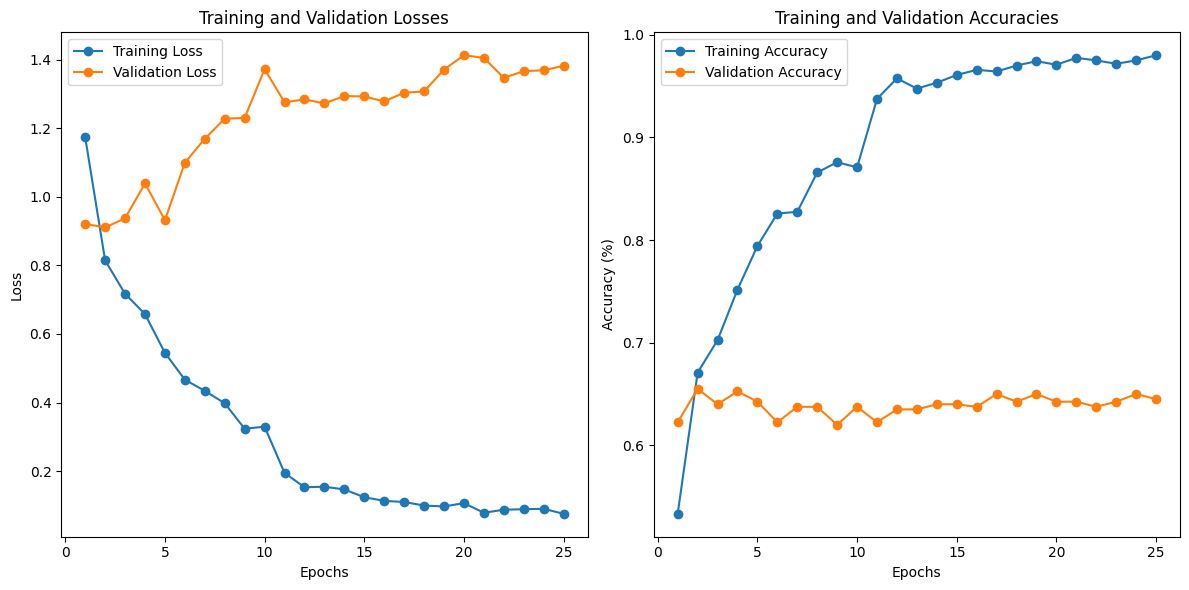

In [23]:
import matplotlib.pyplot as plt

# Data from the provided training results
epochs = list(range(1, 26))
train_losses = [1.1739, 0.8145, 0.7172, 0.6579, 0.5449, 0.4666, 0.4340, 0.3979, 0.3235, 0.3296, 0.1948, 0.1529, 0.1544, 0.1464, 0.1237, 0.1131, 0.1098, 0.0995, 0.0968, 0.1065, 0.0785, 0.0872, 0.0888, 0.0900, 0.0754]
val_losses = [0.9212, 0.9106, 0.9374, 1.0392, 0.9319, 1.0995, 1.1695, 1.2280, 1.2302, 1.3725, 1.2759, 1.2843, 1.2727, 1.2940, 1.2927, 1.2783, 1.3039, 1.3074, 1.3711, 1.4130, 1.4055, 1.3471, 1.3667, 1.3691, 1.3824]
train_accuracies = [0.5333, 0.6708, 0.7025, 0.7517, 0.7942, 0.8258, 0.8275, 0.8658, 0.8758, 0.8708, 0.9375, 0.9575, 0.9475, 0.9533, 0.9608, 0.9658, 0.9642, 0.9700, 0.9742, 0.9708, 0.9775, 0.9750, 0.9717, 0.9750, 0.9800]
val_accuracies = [0.6225, 0.6550, 0.6400, 0.6525, 0.6425, 0.6225, 0.6375, 0.6375, 0.6200, 0.6375, 0.6225, 0.6350, 0.6350, 0.6400, 0.6400, 0.6375, 0.6500, 0.6425, 0.6500, 0.6425, 0.6425, 0.6375, 0.6425, 0.6500, 0.6450]
# Ensure that the lengths of the lists are the same
min_length = min(len(epochs), len(train_losses), len(val_losses), len(train_accuracies), len(val_accuracies))
epochs = epochs[:min_length]
train_losses = train_losses[:min_length]
val_losses = val_losses[:min_length]
train_accuracies = train_accuracies[:min_length]
val_accuracies = val_accuracies[:min_length]

# Plotting the losses
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses,label='Training Loss', marker='o')
plt.plot(epochs,val_losses,label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Plotting the accuracies
plt.subplot(1 ,2 ,2)
plt.plot(epochs ,train_accuracies,label='Training Accuracy', marker='o')
plt.plot(epochs,val_accuracies,label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracies')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


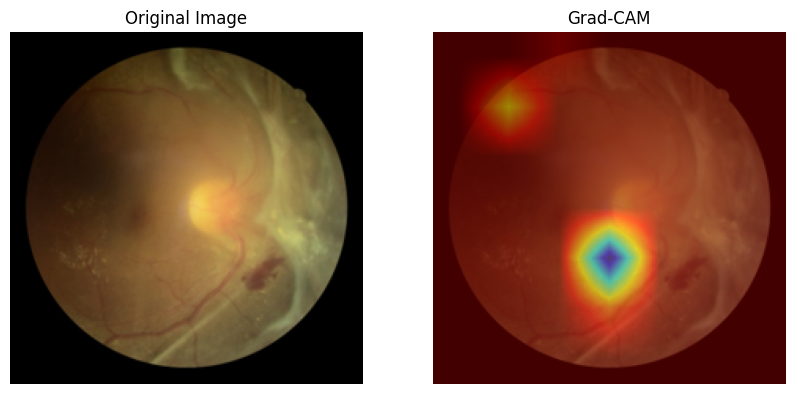

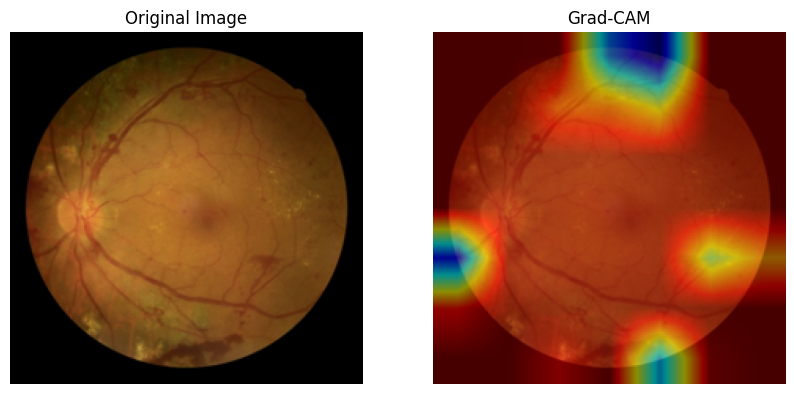

<ipython-input-24-0fc6df68d424>:57: RuntimeWarning: invalid value encountered in divide
  grad_cam_map /= grad_cam_map.max()
<ipython-input-24-0fc6df68d424>:93: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map), cv2.COLORMAP_JET)


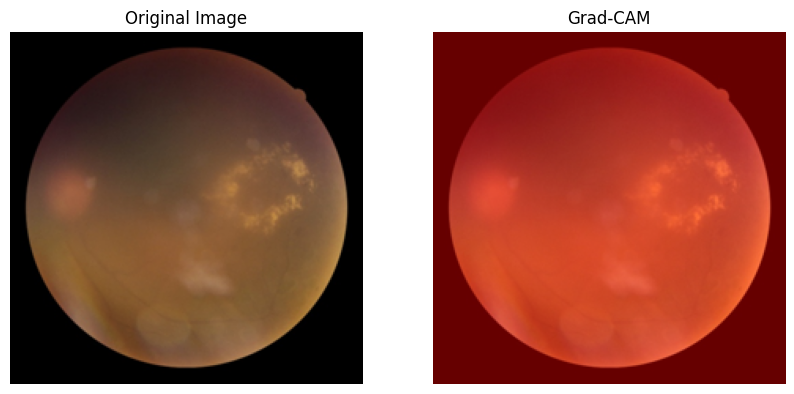

In [24]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define the GradCAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook to get the gradients of the target layer
        target_layer.register_full_backward_hook(self.save_gradients)
        # Hook to get the activations of the target layer
        target_layer.register_forward_hook(self.save_activations)

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def save_activations(self, module, input, output):
        self.activations = output

    def generate(self, input_image, target_class=None):
        # Forward pass
        output = self.model(input_image)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Zero gradients
        self.model.zero_grad()
        # Backward pass with respect to the target class
        output[:, target_class].backward()

        # Get the gradients and activations
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        # Compute the weights
        weights = np.mean(gradients, axis=(1, 2))

        # Compute the Grad-CAM map
        grad_cam_map = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            grad_cam_map += w * activations[i]

        # Apply ReLU to the Grad-CAM map
        grad_cam_map = np.maximum(grad_cam_map, 0)

        # Normalize the Grad-CAM map
        grad_cam_map -= grad_cam_map.min()
        grad_cam_map /= grad_cam_map.max()

        return grad_cam_map

# Load the pre-trained DenseNet201 model with updated weights parameter
model = models.densenet201(pretrained=True)
model.eval()

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the images
image_paths = ['/kaggle/input/deepdrid/DeepDRiD/test/347/347_r1.jpg', '/kaggle/input/deepdrid/DeepDRiD/test/354/354_l2.jpg', '/kaggle/input/deepdrid/DeepDRiD/test/377/377_l1.jpg']  # Replace with your image paths
images = [Image.open(img_path).convert('RGB') for img_path in image_paths]
input_images = torch.stack([transform(img) for img in images])

# Move the input images to the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_images = input_images.to(device)
model.to(device)

# Initialize GradCAM with the model and target layer (last convolutional layer)
grad_cam = GradCAM(model, model.features.denseblock4.denselayer12.conv2)

# Generate and visualize Grad-CAM maps for each image
for i in range(len(images)):
    grad_cam_map = grad_cam.generate(input_images[i].unsqueeze(0))

    # Resize the Grad-CAM map to match the input image size
    grad_cam_map = cv2.resize(grad_cam_map, (224, 224))

    # Convert the Grad-CAM map to a heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # Superimpose the heatmap on the original image
    original_image = np.array(images[i].resize((224, 224))) / 255.0
    superimposed_image = heatmap + original_image
    superimposed_image /= superimposed_image.max()

    # Display the original image and Grad-CAM result side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_image)
    plt.title('Grad-CAM')
    plt.axis('off')

    plt.show()


# Task C: Incorporate attention mechanisms in the model (Self attention mechanism for densenet210)
 

In [25]:

# Self-Attention Module
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, H, W = x.size()
        
        query = self.query_conv(x).view(batch_size, -1, H * W)
        key = self.key_conv(x).view(batch_size, -1, H * W)
        value = self.value_conv(x).view(batch_size, -1, H * W)

        attention = torch.bmm(query.transpose(1, 2), key)  # [B, N, N]
        attention = torch.softmax(attention, dim=-1)  # Normalizing along the dimension N

        out = torch.bmm(value, attention.transpose(1, 2))  # [B, C, N]
        out = out.view(batch_size, C, H, W)  # Reshape the output to the original size
        out = self.gamma * out + x  # Residual connection
        return out

# Modified MyModel class with self-attention
class MyModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.densenet201(pretrained=True)
        self.backbone.classifier = nn.Identity()  # Remove the original classification layer

        self.self_attention = SelfAttention(1920)  # Apply self-attention to DenseNet201's output

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1920, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.backbone.features(x)
        x = self.self_attention(x)  # Apply self-attention
        x = torch.flatten(torch.mean(x, dim=(2, 3)), 1)  # Global average pooling
        x = self.fc(x)
        return x

# Modified MyDualModel class with self-attention
class MyDualModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        backbone = models.densenet201(pretrained=True)
        backbone.fc = nn.Identity()

        self.backbone1 = copy.deepcopy(backbone)
        self.backbone2 = copy.deepcopy(backbone)

        self.self_attention1 = SelfAttention(1920)  # Self-attention on the first backbone
        self.self_attention2 = SelfAttention(1920)  # Self-attention on the second backbone

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1920 * 2, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(1024, num_classes)
        )

    def forward(self, images):
        image1, image2 = images

        x1 = self.backbone1.features(image1)
        x1 = self.self_attention1(x1)  # Apply self-attention to the first image
        x1 = torch.flatten(torch.mean(x1, dim=(2, 3)), 1)

        x2 = self.backbone2.features(image2)
        x2 = self.self_attention2(x2)  # Apply self-attention to the second image
        x2 = torch.flatten(torch.mean(x2, dim=(2, 3)), 1)

        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x

# Evaluation and metrics functions
def evaluate_model(model, test_loader, device, test_only=False, prediction_path='/kaggle/working/test_predictions_densenet201.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                image_ids = [
                    os.path.basename(test_loader.dataset.data[idx]['img_path']) for idx in
                    range(i * test_loader.batch_size, i * test_loader.batch_size + len(images))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        metrics = compute_metrics(all_preds, all_labels)
        return metrics

def compute_metrics(preds, labels, per_class=False):
    kappa = cohen_kappa_score(labels, preds, weights='quadratic')
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)

    # Calculate and print precision and recall for each class
    if per_class:
        precision_per_class = precision_score(labels, preds, average=None, zero_division=0)
        recall_per_class = recall_score(labels, preds, average=None, zero_division=0)
        return kappa, accuracy, precision, recall, precision_per_class, recall_per_class

    return kappa, accuracy, precision, recall

# Main training and evaluation script
if __name__ == '__main__':
    mode = 'single'  # Forward single image to the model each time
    # mode = 'dual'  # Forward two images of the same eye to the model and fuse the features

    assert mode in ('single', 'dual')

    # Define the model
    if mode == 'single':
        model = MyModel()
    else:
        model = MyDualModel()

    print(model, '\n')
    print('Pipeline Mode:', mode)

    # Create datasets (assuming the `RetinopathyDataset` is already defined elsewhere)
    train_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/train.csv', '/kaggle/input/deepdrid/DeepDRiD/train/', transform_train, mode)
    val_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/val.csv', '/kaggle/input/deepdrid/DeepDRiD/val/', transform_test, mode)
    test_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/test.csv', '/kaggle/input/deepdrid/DeepDRiD/test/', transform_test, mode, test=True)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the weighted CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()

    # Use GPU device if possible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    # Move model to device
    model = model.to(device)

    # Optimizer and Learning rate scheduler
    optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train and evaluate the model with the training and validation set
    model = train_model(
        model, train_loader, val_loader, device, criterion, optimizer,
        lr_scheduler=lr_scheduler, num_epochs=num_epochs,
        checkpoint_path='/kaggle/working/densenet201.pth'
    )

    # Load the pretrained checkpoint
    state_dict = torch.load('/kaggle/working/densenet201.pth', map_location='cpu')
    model.load_state_dict(state_dict, strict=True)

    # Make predictions on the testing set and save the prediction results
    evaluate_model(model, test_loader, device, test_only=True)


MyModel(
  (backbone): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.

<ipython-input-25-9a9088d9754e>:210: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/kaggle/working/densenet201.pth', map_location='cpu')


[Val] Kappa: 0.7687 Accuracy: 0.6625 Precision: 0.6509 Recall: 0.6625 Loss: 1.3112
[Val] Best kappa: 0.8063, Epoch 8
Evaluating: 100%|██████████| 17/17 [00:03<00:00,  4.50 batch/s]
[Test] Save predictions to /kaggle/working/test_predictions_densenet201.csv


# Task C: Incorporate attention mechanisms in the model (Spatial attention mechanism for DenseNet)

In [26]:

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)  # Channel-wise average
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # Channel-wise max
        concat_out = torch.cat([avg_out, max_out], dim=1)  # Concatenate along the channel dimension
        attention = self.sigmoid(self.conv1(concat_out))
        return x * attention  # Element-wise multiplication with attention

# Modified MyModel class with spatial attention
class MyModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.densenet201(pretrained=True)
        self.backbone.classifier = nn.Identity()  # Remove the original classification layer

        self.spatial_attention = SpatialAttention()  # Apply spatial attention to DenseNet201's output

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1920, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.backbone.features(x)  # Extract features using DenseNet201
        x = self.spatial_attention(x)  # Apply spatial attention
        x = torch.flatten(torch.mean(x, dim=(2, 3)), 1)  # Global average pooling
        x = self.fc(x)  # Fully connected layers
        return x

# Modified MyDualModel class with spatial attention
class MyDualModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        backbone = models.densenet201(pretrained=True)
        backbone.fc = nn.Identity()

        self.backbone1 = copy.deepcopy(backbone)
        self.backbone2 = copy.deepcopy(backbone)

        self.spatial_attention1 = SpatialAttention()  # Spatial attention on the first backbone
        self.spatial_attention2 = SpatialAttention()  # Spatial attention on the second backbone

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1920 * 2, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(1024, num_classes)
        )

    def forward(self, images):
        image1, image2 = images

        x1 = self.backbone1.features(image1)
        x1 = self.spatial_attention1(x1)  # Apply spatial attention to the first image
        x1 = torch.flatten(torch.mean(x1, dim=(2, 3)), 1)

        x2 = self.backbone2.features(image2)
        x2 = self.spatial_attention2(x2)  # Apply spatial attention to the second image
        x2 = torch.flatten(torch.mean(x2, dim=(2, 3)), 1)

        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x

# Evaluation and metrics functions
def evaluate_model(model, test_loader, device, test_only=False, prediction_path='/kaggle/working/test_predictions_densenet201.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                image_ids = [
                    os.path.basename(test_loader.dataset.data[idx]['img_path']) for idx in
                    range(i * test_loader.batch_size, i * test_loader.batch_size + len(images))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        metrics = compute_metrics(all_preds, all_labels)
        return metrics

def compute_metrics(preds, labels, per_class=False):
    kappa = cohen_kappa_score(labels, preds, weights='quadratic')
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)

    # Calculate and print precision and recall for each class
    if per_class:
        precision_per_class = precision_score(labels, preds, average=None, zero_division=0)
        recall_per_class = recall_score(labels, preds, average=None, zero_division=0)
        return kappa, accuracy, precision, recall, precision_per_class, recall_per_class

    return kappa, accuracy, precision, recall

# Main training and evaluation script
if __name__ == '__main__':
    mode = 'single'  # Forward single image to the model each time
    # mode = 'dual'  # Forward two images of the same eye to the model and fuse the features

    assert mode in ('single', 'dual')

    # Define the model
    if mode == 'single':
        model = MyModel()
    else:
        model = MyDualModel()

    print(model, '\n')
    print('Pipeline Mode:', mode)

    # Create datasets (assuming the `RetinopathyDataset` is already defined elsewhere)
    train_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/train.csv', '/kaggle/input/deepdrid/DeepDRiD/train/', transform_train, mode)
    val_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/val.csv', '/kaggle/input/deepdrid/DeepDRiD/val/', transform_test, mode)
    test_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/test.csv', '/kaggle/input/deepdrid/DeepDRiD/test/', transform_test, mode, test=True)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the weighted CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()

    # Use GPU device if possible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    # Move model to device
    model = model.to(device)

    # Optimizer and Learning rate scheduler
    optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train and evaluate the model with the training and validation set
    model = train_model(
        model, train_loader, val_loader, device, criterion, optimizer,
        lr_scheduler=lr_scheduler, num_epochs=num_epochs
        
    )

    # Load the pretrained checkpoint
    state_dict = torch.load('/kaggle/workingfd/densenet201.pth', map_location='cpu')
    model.load_state_dict(state_dict, strict=True)

    # Make predictions on the testing set and save the prediction results
    evaluate_model(model, test_loader, device, test_only=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MyModel(
  (backbone): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.

<ipython-input-26-c3621def721e>:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/kaggle/workingfd/densenet201.pth', map_location='cpu')


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/workingfd/densenet201.pth'

# Task a: Fine-tune a pretrained model using the DeepDRiD dataset (EfficientNet)  

In [27]:
def train_model(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs=25,
                checkpoint_path='/kaggle/working/Efficientnetmodel.pth'):
    best_model = model.state_dict()
    best_epoch = None
    best_val_kappa = -1.0  # Initialize the best kappa score

    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        running_loss = []
        all_preds = []
        all_labels = []

        model.train()

        # Training Phase
        with tqdm(total=len(train_loader), desc=f'Training', unit=' batch', file=sys.stdout) as pbar:
            for images, labels in train_loader:
                if not isinstance(images, list):
                    images = images.to(device)  # single image case
                else:
                    images = [x.to(device) for x in images]  # dual images case

                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(images)
                loss = criterion(outputs, labels.long())

                loss.backward()
                optimizer.step()

                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                running_loss.append(loss.item())

                pbar.set_postfix({'lr': f'{optimizer.param_groups[0]["lr"]:.1e}', 'Loss': f'{loss.item():.4f}'})
                pbar.update(1)

        lr_scheduler.step()

        epoch_loss = sum(running_loss) / len(running_loss)

        train_metrics = compute_metrics(all_preds, all_labels, per_class=True)
        kappa, accuracy, precision, recall = train_metrics[:4]

        print(f'[Train] Kappa: {kappa:.4f} Accuracy: {accuracy:.4f} '
              f'Precision: {precision:.4f} Recall: {recall:.4f} Loss: {epoch_loss:.4f}')

        if len(train_metrics) > 4:
            precision_per_class, recall_per_class = train_metrics[4:]
            for i, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
                print(f'[Train] Class {i}: Precision: {precision:.4f}, Recall: {recall:.4f}')

        # Validation Phase
        model.eval()
        val_loss = []
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                if not isinstance(images, list):
                    images = images.to(device)  # single image case
                else:
                    images = [x.to(device) for x in images]  # dual images case

                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels.long())
                val_loss.append(loss.item())

                preds = torch.argmax(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss = sum(val_loss) / len(val_loss)

        val_metrics = compute_metrics(val_preds, val_labels, per_class=False)
        val_kappa, val_accuracy, val_precision, val_recall = val_metrics[:4]

        print(f'[Val] Kappa: {val_kappa:.4f} Accuracy: {val_accuracy:.4f} '
              f'Precision: {val_precision:.4f} Recall: {val_recall:.4f} Loss: {val_loss:.4f}')

        # Save the best model
        if val_kappa > best_val_kappa:
            best_val_kappa = val_kappa
            best_epoch = epoch
            best_model = model.state_dict()
            torch.save(best_model, checkpoint_path)

    print(f'[Val] Best kappa: {best_val_kappa:.4f}, Epoch {best_epoch}')

    return model


def evaluate_model(model, test_loader, device, test_only=False, prediction_path='/kaggle/working/test_predictions_efficientNet.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                image_ids = [
                    os.path.basename(test_loader.dataset.data[idx]['img_path']) for idx in
                    range(i * test_loader.batch_size, i * test_loader.batch_size + len(images))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        metrics = compute_metrics(all_preds, all_labels)
        return metrics


def compute_metrics(preds, labels, per_class=False):
    kappa = cohen_kappa_score(labels, preds, weights='quadratic')
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)

    # Calculate and print precision and recall for each class
    if per_class:
        precision_per_class = precision_score(labels, preds, average=None, zero_division=0)
        recall_per_class = recall_score(labels, preds, average=None, zero_division=0)
        return kappa, accuracy, precision, recall, precision_per_class, recall_per_class

    return kappa, accuracy, precision, recall

# Model for single image input
class MyEfficientNetModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.efficientnet_b0(pretrained=True)  # Using EfficientNet-B0
        self.backbone.classifier = nn.Identity()  # Remove the original classification layer

        # Fully connected layer for final classification
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1280, 1024),  # EfficientNet-B0 has 1280-dimensional features
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.backbone.features(x)
        x = torch.flatten(torch.mean(x, dim=(2, 3)), 1)  # Global average pooling
        x = self.fc(x)
        return x


# Model for dual image input
class MyDualEfficientNetModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        backbone = models.efficientnet_b0(pretrained=True)  # Using EfficientNet-B0
        backbone.classifier = nn.Identity()

        # Two separate backbones with unshared weights
        self.backbone1 = copy.deepcopy(backbone)
        self.backbone2 = copy.deepcopy(backbone)

        # Fully connected layer for final classification
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1280 * 2, 1024),  # Concatenation of features from two EfficientNet-B0 backbones
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(1024, num_classes)
        )

    def forward(self, images):
        image1, image2 = images

        x1 = self.backbone1.features(image1)
        x1 = torch.flatten(torch.mean(x1, dim=(2, 3)), 1)

        x2 = self.backbone2.features(image2)
        x2 = torch.flatten(torch.mean(x2, dim=(2, 3)), 1)

        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x


if __name__ == '__main__':
    # Choose between 'single image' and 'dual images' pipeline
    mode = 'single'  # forward single image to the model each time
    # mode = 'dual'  # forward two images of the same eye to the model and fuse the features

    assert mode in ('single', 'dual')

    # Define the model
    if mode == 'single':
        model = MyEfficientNetModel()
    else:
        model = MyDualEfficientNetModel()

    print(model, '\n')
    print('Pipeline Mode:', mode)

    # Create datasets
    train_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/train.csv', '/kaggle/input/deepdrid/DeepDRiD/train/', transform_train, mode)
    val_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/val.csv', '/kaggle/input/deepdrid/DeepDRiD/val/', transform_test, mode)
    test_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/test.csv', '/kaggle/input/deepdrid/DeepDRiD/test/', transform_test, mode, test=True)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the weighted CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()

    # Use GPU device if possible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    # Move model to the device
    model = model.to(device)

    # Optimizer and Learning rate scheduler
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train and evaluate the model with the training and validation set
    model = train_model(
        model, train_loader, val_loader, device, criterion, optimizer,
        lr_scheduler=lr_scheduler, num_epochs=num_epochs,
        checkpoint_path='/kaggle/working/efficientnet.pth'
    )

    # Load the pretrained checkpoint
    state_dict = torch.load('/kaggle/working/efficientnet.pth', map_location='cpu')
    model.load_state_dict(state_dict, strict=True)

    # Make predictions on testing set and save the prediction results
    evaluate_model(model, test_loader, device, test_only=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MyEfficientNetModel(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
             

<ipython-input-27-aa4d66cd9f5a>:282: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/kaggle/working/efficientnet.pth', map_location='cpu')


[Val] Kappa: 0.7744 Accuracy: 0.6700 Precision: 0.6553 Recall: 0.6700 Loss: 1.0068
[Val] Best kappa: 0.8009, Epoch 14
Evaluating: 100%|██████████| 17/17 [00:02<00:00,  5.95 batch/s]
[Test] Save predictions to /kaggle/working/test_predictions_efficientNet.csv


# Task e: Creating Visualizations and Explainable AI (Efficientnet)

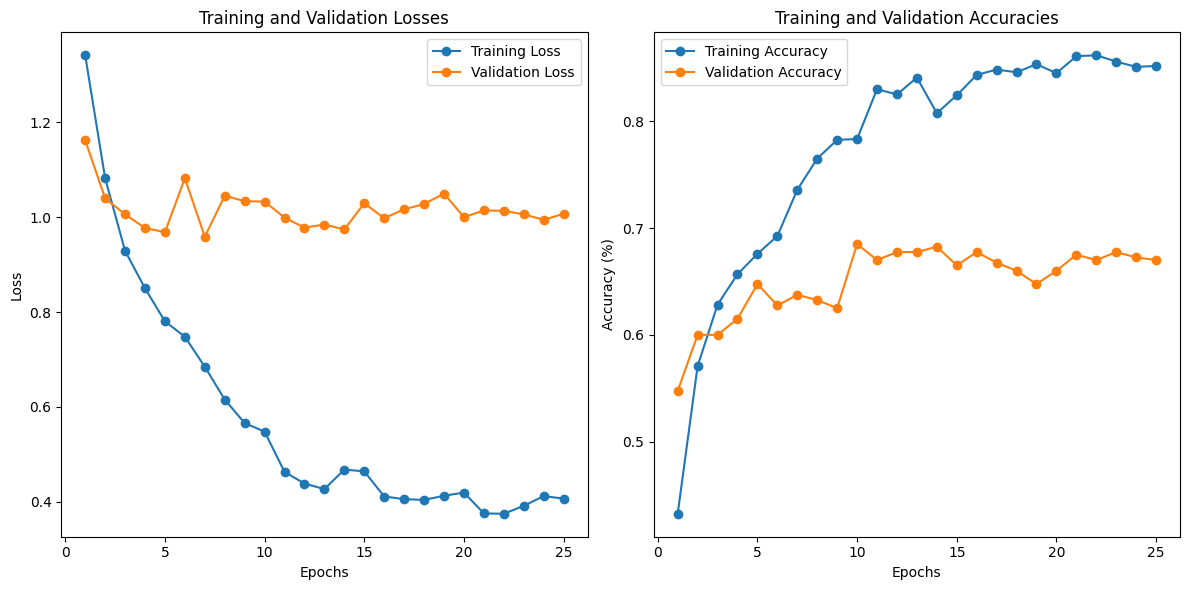

In [28]:
import matplotlib.pyplot as plt


epochs = list(range(1, 26))
train_losses = [1.3406, 1.0816, 0.9287, 0.8499, 0.7803, 0.7480, 0.6847, 0.6157, 0.5661, 0.5481, 0.4633, 0.4388, 0.4271, 0.4682, 0.4645, 0.4115, 0.4060, 0.4043, 0.4131, 0.4198, 0.3760, 0.3751, 0.3918, 0.4124, 0.4071]
val_losses = [1.1614, 1.0394, 1.0057, 0.9768, 0.9681, 1.0816, 0.9586, 1.0449, 1.0333, 1.0325, 0.9987, 0.9777, 0.9842, 0.9738, 1.0290, 0.9975, 1.0162, 1.0274, 1.0492, 0.9998, 1.0138, 1.0131, 1.0056, 0.9941, 1.0068]
train_accuracies = [0.4325, 0.5708, 0.6283, 0.6567, 0.6758, 0.6925, 0.7358, 0.7650, 0.7825, 0.7833, 0.8300, 0.8250, 0.8408, 0.8075, 0.8242, 0.8433, 0.8483, 0.8458, 0.8533, 0.8450, 0.8608, 0.8617, 0.8558, 0.8508, 0.8517]
val_accuracies = [0.5475, 0.6000, 0.6000, 0.6150, 0.6475, 0.6275, 0.6375, 0.6325, 0.6250, 0.6850, 0.6700, 0.6775, 0.6775, 0.6825, 0.6650, 0.6775, 0.6675, 0.6600, 0.6475, 0.6600, 0.6750, 0.6700, 0.6775, 0.6725, 0.6700]


min_length = min(len(epochs), len(train_losses), len(val_losses), len(train_accuracies), len(val_accuracies))
epochs = epochs[:min_length]
train_losses = train_losses[:min_length]
val_losses = val_losses[:min_length]
train_accuracies = train_accuracies[:min_length]
val_accuracies = val_accuracies[:min_length]

# Plotting the losses
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses,label='Training Loss', marker='o')
plt.plot(epochs,val_losses,label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Plotting the accuracies
plt.subplot(1 ,2 ,2)
plt.plot(epochs ,train_accuracies,label='Training Accuracy', marker='o')
plt.plot(epochs,val_accuracies,label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracies')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

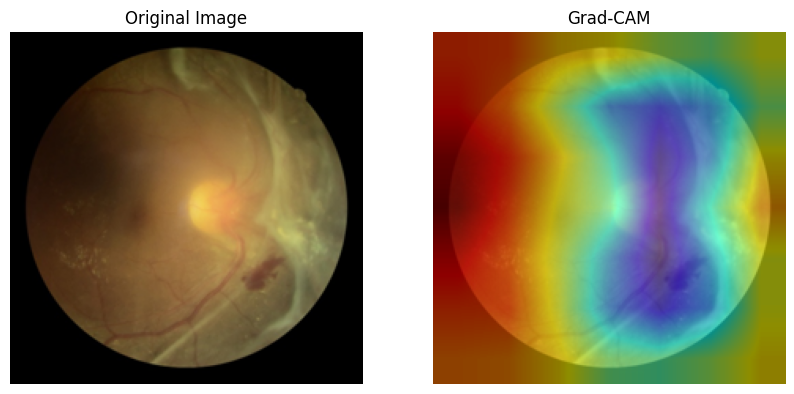

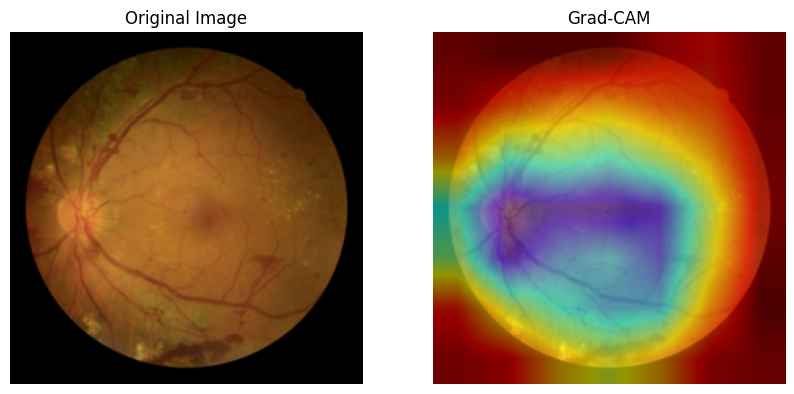

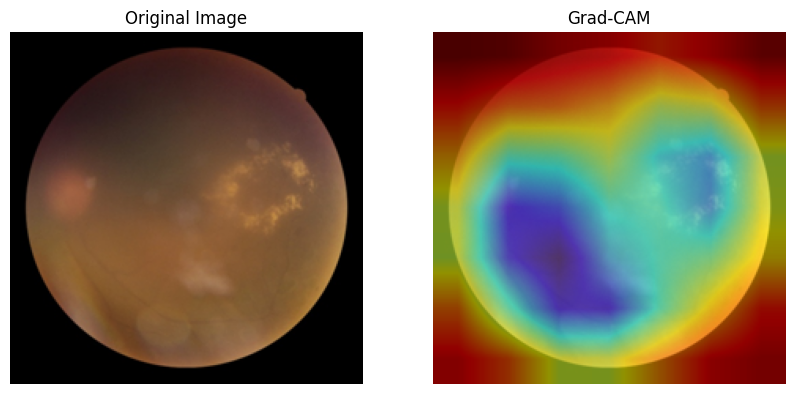

In [29]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define the GradCAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook to get the gradients of the target layer
        target_layer.register_full_backward_hook(self.save_gradients)
        # Hook to get the activations of the target layer
        target_layer.register_forward_hook(self.save_activations)

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def save_activations(self, module, input, output):
        self.activations = output

    def generate(self, input_image, target_class=None):
        # Forward pass
        output = self.model(input_image)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Zero gradients
        self.model.zero_grad()
        # Backward pass with respect to the target class
        output[:, target_class].backward()

        # Get the gradients and activations
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        # Compute the weights
        weights = np.mean(gradients, axis=(1, 2))

        # Compute the Grad-CAM map
        grad_cam_map = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            grad_cam_map += w * activations[i]

        # Apply ReLU to the Grad-CAM map
        grad_cam_map = np.maximum(grad_cam_map, 0)

        # Normalize the Grad-CAM map
        grad_cam_map -= grad_cam_map.min()
        grad_cam_map /= grad_cam_map.max()

        return grad_cam_map

# Load the pre-trained EfficientNet-B0 model
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
model.eval()

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the images
image_paths = ['/kaggle/input/deepdrid/DeepDRiD/test/347/347_r1.jpg', '/kaggle/input/deepdrid/DeepDRiD/test/354/354_l2.jpg', '/kaggle/input/deepdrid/DeepDRiD/test/377/377_l1.jpg'] # Replace with your image paths
images = [Image.open(img_path).convert('RGB') for img_path in image_paths]
input_images = torch.stack([transform(img) for img in images])

# Move the input images to the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_images = input_images.to(device)
model.to(device)

# Initialize GradCAM with the model and target layer (last convolutional layer)
grad_cam = GradCAM(model, model.features[-1][0])

# Generate and visualize Grad-CAM maps for each image
for i in range(len(images)):
    grad_cam_map = grad_cam.generate(input_images[i].unsqueeze(0))

    # Resize the Grad-CAM map to match the input image size
    grad_cam_map = cv2.resize(grad_cam_map, (224, 224))

    # Convert the Grad-CAM map to a heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # Superimpose the heatmap on the original image
    original_image = np.array(images[i].resize((224, 224))) / 255.0
    superimposed_image = heatmap + original_image
    superimposed_image /= superimposed_image.max()

    # Display the original image and Grad-CAM result side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_image)
    plt.title('Grad-CAM')
    plt.axis('off')

    plt.show()

# Task C: Incorporate attention mechanisms in the model (Spatial attention mechanism for Efficientnet)

In [30]:


# Spatial Attention Mechanism
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_pool, max_pool], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

# Model for single image input with spatial attention
class MyEfficientNetModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.efficientnet_b0(pretrained=True)  # Using EfficientNet-B0
        self.backbone.classifier = nn.Identity()  # Remove the original classification layer

        # Spatial Attention
        self.spatial_attention = SpatialAttention()

        # Fully connected layer for final classification
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1280, 1024),  # EfficientNet-B0 has 1280-dimensional features
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.backbone.features(x)
        x = self.spatial_attention(x) * x  # Apply spatial attention
        x = torch.flatten(torch.mean(x, dim=(2, 3)), 1)  # Global average pooling
        x = self.fc(x)
        return x


# Model for dual image input with spatial attention
class MyDualEfficientNetModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        backbone = models.efficientnet_b0(pretrained=True)  # Using EfficientNet-B0
        backbone.classifier = nn.Identity()

        # Two separate backbones with unshared weights
        self.backbone1 = copy.deepcopy(backbone)
        self.backbone2 = copy.deepcopy(backbone)

        # Spatial Attention
        self.spatial_attention1 = SpatialAttention()
        self.spatial_attention2 = SpatialAttention()

        # Fully connected layer for final classification
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1280 * 2, 1024),  # Concatenation of features from two EfficientNet-B0 backbones
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(1024, num_classes)
        )

    def forward(self, images):
        image1, image2 = images

        x1 = self.backbone1.features(image1)
        x1 = self.spatial_attention1(x1) * x1  # Apply spatial attention to image1
        x1 = torch.flatten(torch.mean(x1, dim=(2, 3)), 1)

        x2 = self.backbone2.features(image2)
        x2 = self.spatial_attention2(x2) * x2  # Apply spatial attention to image2
        x2 = torch.flatten(torch.mean(x2, dim=(2, 3)), 1)

        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x


def evaluate_model(model, test_loader, device, test_only=False, prediction_path='/kaggle/working/test_predictions_efficientnet.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                image_ids = [
                    os.path.basename(test_loader.dataset.data[idx]['img_path']) for idx in
                    range(i * test_loader.batch_size, i * test_loader.batch_size + len(images))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        metrics = compute_metrics(all_preds, all_labels)
        return metrics


def compute_metrics(preds, labels, per_class=False):
    kappa = cohen_kappa_score(labels, preds, weights='quadratic')
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)

    # Calculate and print precision and recall for each class
    if per_class:
        precision_per_class = precision_score(labels, preds, average=None, zero_division=0)
        recall_per_class = recall_score(labels, preds, average=None, zero_division=0)
        return kappa, accuracy, precision, recall, precision_per_class, recall_per_class

    return kappa, accuracy, precision, recall

# Model training and evaluation pipeline
if __name__ == '__main__':
    # Choose between 'single image' and 'dual images' pipeline
    mode = 'single'  # forward single image to the model each time
    # mode = 'dual'  # forward two images of the same eye to the model and fuse the features

    assert mode in ('single', 'dual')

    # Define the model
    if mode == 'single':
        model = MyEfficientNetModel()
    else:
        model = MyDualEfficientNetModel()

    print(model, '\n')
    print('Pipeline Mode:', mode)

    # Create datasets
    train_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/train.csv', '/kaggle/input/deepdrid/DeepDRiD/train/', transform_train, mode)
    val_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/val.csv', '/kaggle/input/deepdrid/DeepDRiD/val/', transform_test, mode)
    test_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/test.csv', '/kaggle/input/deepdrid/DeepDRiD/test/', transform_test, mode, test=True)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the weighted CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()

    # Use GPU device if possible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    # Move model to the device
    model = model.to(device)

    # Optimizer and Learning rate scheduler
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train and evaluate the model with the training and validation set
    model = train_model(
        model, train_loader, val_loader, device, criterion, optimizer,
        lr_scheduler=lr_scheduler, num_epochs=num_epochs,
        checkpoint_path='/kaggle/working/efficientnet.pth'
    )

    # Load the pretrained checkpoint
    state_dict = torch.load('/kaggle/working/efficientnet.pth', map_location='cpu')
    model.load_state_dict(state_dict, strict=True)

    # Make predictions on testing set and save the prediction results
    evaluate_model(model, test_loader, device, test_only=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MyEfficientNetModel(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
             

<ipython-input-30-b2ba8dc20d73>:208: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/kaggle/working/efficientnet.pth', map_location='cpu')


[Val] Kappa: 0.7443 Accuracy: 0.6275 Precision: 0.6162 Recall: 0.6275 Loss: 1.1449
[Val] Best kappa: 0.7831, Epoch 19
Evaluating: 100%|██████████| 17/17 [00:03<00:00,  5.39 batch/s]
[Test] Save predictions to /kaggle/working/test_predictions_efficientnet.csv


# Task C: Incorporate attention mechanisms in the model (Self-attention mechanism for Efficientnet)

In [31]:


# Self-Attention Mechanism
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.query = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, H, W = x.size()
        query = self.query(x).view(batch_size, -1, H * W).permute(0, 2, 1)  # B x (H*W) x C//8
        key = self.key(x).view(batch_size, -1, H * W)  # B x C//8 x (H*W)
        energy = torch.bmm(query, key)  # B x (H*W) x (H*W)
        attention = F.softmax(energy, dim=-1)  # B x (H*W) x (H*W)

        value = self.value(x).view(batch_size, -1, H * W)  # B x C x (H*W)
        out = torch.bmm(value, attention.permute(0, 2, 1))  # B x C x (H*W)
        out = out.view(batch_size, C, H, W)

        out = self.gamma * out + x
        return out

# Model for single image input with Self-Attention
class MyEfficientNetModelWithAttention(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.efficientnet_b0(pretrained=True)
        self.backbone.classifier = nn.Identity()

        # Add Self-Attention mechanism after feature extraction
        self.attention = SelfAttention(1280)  # EfficientNet-B0 feature size is 1280

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1280, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.backbone.features(x)
        x = self.attention(x)  # Apply self-attention
        x = torch.flatten(torch.mean(x, dim=(2, 3)), 1)  # Global average pooling
        x = self.fc(x)
        return x

# Model for dual image input with Self-Attention
class MyDualEfficientNetModelWithAttention(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        backbone = models.efficientnet_b0(pretrained=True)
        backbone.classifier = nn.Identity()

        self.backbone1 = copy.deepcopy(backbone)
        self.backbone2 = copy.deepcopy(backbone)

        self.attention1 = SelfAttention(1280)
        self.attention2 = SelfAttention(1280)

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1280 * 2, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(1024, num_classes)
        )

    def forward(self, images):
        image1, image2 = images

        x1 = self.backbone1.features(image1)
        x1 = self.attention1(x1)
        x1 = torch.flatten(torch.mean(x1, dim=(2, 3)), 1)

        x2 = self.backbone2.features(image2)
        x2 = self.attention2(x2)
        x2 = torch.flatten(torch.mean(x2, dim=(2, 3)), 1)

        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x

if __name__ == '__main__':
    mode = 'single'  # Choose between 'single' and 'dual'
    assert mode in ('single', 'dual')

    if mode == 'single':
        model = MyEfficientNetModelWithAttention()
    else:
        model = MyDualEfficientNetModelWithAttention()

    print(model, '\n')
    print('Pipeline Mode:', mode)

    # Dataset and Dataloader initialization (placeholders)
    train_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/train.csv', '/kaggle/input/deepdrid/DeepDRiD/train/', transform_train, mode)
    val_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/val.csv', '/kaggle/input/deepdrid/DeepDRiD/val/', transform_test, mode)
    test_dataset = RetinopathyDataset('/kaggle/input/deepdrid/DeepDRiD/test.csv', '/kaggle/input/deepdrid/DeepDRiD/test/', transform_test, mode, test=True)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    model = model.to(device)

    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train and evaluate (functions `train_model` and `evaluate_model` remain the same)
    model = train_model(
        model, train_loader, val_loader, device, criterion, optimizer,
        lr_scheduler=lr_scheduler, num_epochs=25, checkpoint_path='/kaggle/working/efficientnet_attention.pth'
    )

    # Test the model
    state_dict = torch.load('/kaggle/working/efficientnet_attention.pth', map_location='cpu')
    model.load_state_dict(state_dict, strict=True)
    evaluate_model(model, test_loader, device, test_only=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MyEfficientNetModelWithAttention(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)


<ipython-input-31-e0c6cb982ac5>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/kaggle/working/efficientnet_attention.pth', map_location='cpu')


[Val] Kappa: 0.7866 Accuracy: 0.6650 Precision: 0.6347 Recall: 0.6650 Loss: 1.1438
[Val] Best kappa: 0.7949, Epoch 19
Evaluating: 100%|██████████| 25/25 [00:02<00:00,  8.73 batch/s]
[Test] Save predictions to /kaggle/working/test_predictions_efficientnet.csv
